In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
import datetime
import pyarrow.parquet as pq
import pyarrow as pa
import os
import time
import matplotlib.dates as md
import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import seaborn as sns
import random

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay

from IPython.display import display, HTML
import ipywidgets

import joblib

import shap

%matplotlib inline

In [3]:
start = time.time()
file_loc = 'data/eight_state_study_with_model_scores.parquet'
analysis_df = pq.ParquetDataset(file_loc).read_pandas().to_pandas()
print(f"... completed in {time.time() - start} seconds")

... completed in 0.019676923751831055 seconds


In [4]:
models = {
    'model1_lr' : {
        'name': 'model1_lr',
        'type': 'linear',
        'scoring_metric': 'roc_auc',
        'path': 'model1_lr',
        'version': '',
        'label': 'model1_lr',
        'classes': {
            1: {
                'path': 'model1_lr',
                'version': '',
                'append': ''
            }
        }
    },
    'model1_rf' : {
        'name': 'model1_rf',
        'type': 'tree',
        'scoring_metric': 'roc_auc',
        'path': 'model1_rf',
        'version': '',
        'label': 'model1_rf',
        'classes': {
            1: {
                'path': 'model1_rf',
                'version': '',
                'append': ''
            }
        }
    },
    'model1_svm' : {
        'name': 'model1_svm',
        'type': 'linear',
        'scoring_metric': 'roc_auc',
        'path': 'model1_svm',
        'version': '',
        'label': 'model1_svm',
        'classes': {
            1: {
                'path': 'model1_svm',
                'version': '',
                'append': ''
            }
        }
    },
    'model2_lr' : {
        'name': 'model2_lr',
        'type': 'linear',
        'scoring_metric': 'roc_auc',
        'path': 'model2_lr',
        'version': '',
        'label': 'model2_lr',
        'classes': {
            1: {
                'path': 'model2_lr',
                'version': '',
                'append': 'biden'
            },
            2: {
                'path': 'model2_lr',
                'version': '',
                'append': 'trump'
            }
        }
    },
    'model3_lr' : {
        'name': 'model3_lr',
        'type': 'linear',
        'scoring_metric': 'f1_weighted',
        'path': 'model3_lr',
        'version': '',
        'label': 'model3_lr',
        'classes': {
            1: {
                'path': 'model3_lr',
                'version': '',
                'append': ''
            }
        }
    },
    'model4_lr' : {
        'name': 'model4_lr',
        'type': 'linear',
        'scoring_metric': 'roc_auc',
        'path': 'model4_lr',
        'version': '',
        'label': 'model4_lr',
        'classes': {
            1: {
                'path': 'model4_lr',
                'version': '',
                'append': ''
            }
        }
    },
    'model4_rf' : {
        'name': 'model4_rf',
        'type': 'tree',
        'scoring_metric': 'roc_auc',
        'path': 'model4_rf',
        'version': '',
        'label': 'model4_rf',
        'classes': {
            1: {
                'path': 'model4_rf',
                'version': '',
                'append': ''
            }
        }
    },
    'model4_xgb' : {
        'name': 'model4_xgb',
        'type': 'tree',
        'scoring_metric': 'roc_auc',
        'path': 'model4_xgb',
        'version': '',
        'label': 'model4_xgb',
        'classes': {
            1: {
                'path': 'model4_xgb',
                'version': '',
                'append': ''
            }
        }
    },
    'model4_lgbm' : {
        'name': 'model4_lgbm',
        'type': 'tree',
        'scoring_metric': 'average_precision',
        'path': 'model4_lgbm',
        'version': '',
        'label': 'model4_lgbm',
        'classes': {
            1: {
                'path': 'model4_lgbm',
                'version': '',
                'append': ''
            }
        }
    },
    'model5_lr' : {
        'name': 'model5_lr',
        'type': 'linear',
        'scoring_metric': 'average_precision',
        'path': 'model5_lr',
        'version': '',
        'label': 'model5_lr',
        'classes': {
            1: {
                'path': 'model5_lr',
                'version': '',
                'append': ''
            }
        }
    },
    'model5_lgbm' : {
        'name': 'model5_lgbm',
        'type': 'tree',
        'scoring_metric': 'average_precision',
        'path': 'model5_lgbm',
        'version': '',
        'label': 'model5_lgbm',
        'classes': {
            1: {
                'path': 'model5_lgbm',
                'version': '',
                'append': ''
            }
        }
    }
}

In [5]:
# a pickle loader to iteratively work with the model dictionary
def load_model_from_pickle(dir_path, class_path):
    joblib_pickle_loc = '{}/{}.pkl'.format(dir_path, class_path)
    # load the model
    model = joblib.load(joblib_pickle_loc)
    # retrieve the feature columns
    X_cols = pd.read_csv('{}/{}_cols.csv'.format(dir_path, class_path)).iloc[:,0].to_list()
    return (model, X_cols)

In [6]:
def score_model_wrapper(y_true, y_pred, y_prob, train_range, test_range, model_name):
    print('')
    display(HTML("<h2>Model Scores and Errors</h2>"))

    display(HTML("<h3>Training Data</h3>"))
    score_model(y_true[train_range], y_pred[train_range], y_prob[train_range], model_name)
    display(HTML("<h3>Test Data</h3>"))
    score_model(y_true[test_range], y_pred[test_range], y_prob[test_range], model_name)


In [7]:
def score_model(y_true, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = average_precision_score(y_true, y_prob)
    rocauc = roc_auc_score(y_true, y_prob)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    specificity = TN / float(TN + FP)
    false_positive_rate = FP / float(TN + FP)
    print('')
    print('classification accuracy:', round(accuracy,4))
    print('misclassification rate:', round(1-accuracy,4))
    print('sensitivity (true positive rate) aka recall:', round(recall,4))
    print('specificity:', round(specificity,4))
    print('false positive rate:', round(false_positive_rate,4))
    print('precision:', round(precision,4))
    print('f1 score:', round(f1,4))
    print('roc auc:', round(rocauc,4))
    print('cohens kappa:', round(kappa,4))
    print('mcc:', round(mcc,4))        
    print('mse:', round(mse,4))
    print('confusion:')
    print(confusion)
    print('')

In [8]:
def feature_importance(model, X_cols, model_type, model_name):
    display(HTML("<h2>Feature Importance for " + model_name + "</h2>"))
    feat_importance = pd.DataFrame()
    if model_type == 'linear':
        feat_importance = pd.DataFrame([model.coef_[0]], columns=X_cols).T
        feat_importance.columns = ['coef']
        feat_importance['abs_coef'] = np.abs(feat_importance['coef'])
        feat_importance.sort_values('abs_coef', ascending=False, inplace=True)
    elif (model_type == 'tree') | (model_type == 'ada'):
        feat_importance = pd.DataFrame([model.feature_importances_], columns=X_cols).T
        feat_importance.columns = ['importance']
        feat_importance.sort_values('importance', ascending=False, inplace=True)
    return(feat_importance)

In [9]:
def plot_error_distribution_wrapper(y_true, y_pred, y_baseline_pred, train_range, test_range, baseline_range, model_name):
    display(HTML("<h2>Error Distribution - Train vs Test vs Baseline</h2>"))

    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(16,4))
    
    plot_error_distribution(y_true[train_range], y_pred[train_range], 'Training Data', ax[0])
    plot_error_distribution(y_true[test_range], y_pred[test_range], 'Test Data', ax[1])
    plot_error_distribution(y_true[baseline_range], y_baseline_pred[baseline_range], 'Baseline', ax[2])

    plt.show()


In [10]:
def plot_error_distribution(y_true, y_pred, model_name, ax=None):
    error_df = pd.Series(data=y_pred-y_true, name='Error')
    ax = error_df.hist(ax=ax)
    #ax = sns.histplot(error_df, ax=ax)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title('Error Distribution on '+ model_name)
    ax.set_xlabel('Type 2 Error         Correct Inference         Type 1 Error')
    ax.set_ylabel('Density')


In [11]:
def plot_roc_curve_wrapper(y_true, y_pred, y_prob, y_baseline_pred, y_baseline_prob, train_range, test_range, baseline_range, model_name):
    display(HTML("<h2>ROC Curve - Train vs Test vs Baseline</h2>"))

    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(16,4))
    
    plot_roc_curve(y_true[train_range], y_pred[train_range], y_prob[train_range], 'Training Data', ax=ax[0])
    plot_roc_curve(y_true[test_range], y_pred[test_range], y_prob[test_range], 'Test Data', ax=ax[1])
    plot_roc_curve(y_true[baseline_range], y_baseline_pred[baseline_range], y_baseline_prob[baseline_range], 'Baseline', ax=ax[2])

    plt.show()


In [12]:
def plot_roc_curve(y_true, y_pred, y_prob, model_name, ax=None):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_true))]
    # keep probabilities for the positive outcome only
    lr_probs = y_prob #[y_pred == 1]

    # calculate scores
    ns_auc = roc_auc_score(y_true, ns_probs)
    lr_auc = roc_auc_score(y_true, lr_probs)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_probs)
    
    # plot the roc curve for the model
    if ax:
        ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        ax.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
        ax.set_title('ROC Curve on '+ model_name)
        # axis labels
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        # add the legend
        ax.legend()
    else:
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
        plt.title('ROC Curve on '+ model_name)        
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # add the legend
        plt.legend()

In [13]:
def plot_pr_curve_wrapper(y_true, y_pred, y_prob, y_baseline_pred, y_baseline_prob, train_range, test_range, baseline_range, model_name):
    display(HTML("<h2>Precision-Recall Curve - Train vs Test vs Baseline</h2>"))

    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(16,4))
    
    plot_pr_curve(y_true[train_range], y_pred[train_range], y_prob[train_range], 'Training Data', ax=ax[0])
    plot_pr_curve(y_true[test_range], y_pred[test_range], y_prob[test_range], 'Test Data', ax=ax[1])
    plot_pr_curve(y_true[baseline_range], y_baseline_pred[baseline_range], y_baseline_prob[baseline_range], 'Baseline', ax=ax[2])

    plt.show()    

In [14]:
def plot_pr_curve(y_true, y_pred, y_prob, model_name, ax=None):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_true))]
    # keep probabilities for the positive outcome only
    lr_probs = y_prob #[y_pred == 1]

    # calculate precision-recall curves
    lr_precision, lr_recall, _ = precision_recall_curve(y_true, lr_probs)
    lr_f1, lr_auc = f1_score(y_true, y_pred), auc(lr_recall, lr_precision)    
    
    # plot the precision-recall curves
    no_skill = len(y_true[y_true==1]) / len(y_true)
    if ax:
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        ax.plot(lr_recall, lr_precision, marker='.', label=model_name)
        ax.set_title('P-R Curve on '+ model_name)
        # axis labels
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        # add the legend
        ax.legend()        
    else:
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        plt.plot(lr_recall, lr_precision, marker='.', label=model_name)
        plt.title('P-R Curve on '+ model_name)
        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        # add the legend
        plt.legend()

In [15]:
def plot_confusion_matrix_wrapper(y_true, y_pred, y_baseline_pred, train_range, test_range, baseline_range, model_name):
    display(HTML("<h2>Confusion Matrix - Train vs Test vs Baseline</h2>"))
    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(16,4))
    plot_confusion_matrix(y_true[train_range], y_pred[train_range], 'Training Data', ax=ax[0])
    plot_confusion_matrix(y_true[test_range], y_pred[test_range], 'Test Data', ax=ax[1])
    plot_confusion_matrix(y_true[baseline_range], y_baseline_pred[baseline_range], 'Baseline', ax=ax[2])
    
    plt.show()

In [16]:
def plot_confusion_matrix(y_true, y_pred, model_name, ax=None): 
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred, normalize='true'),
                                  display_labels=['Decided', 'Undecided'])
    disp.plot(ax=ax, cmap='Blues').ax_.set_title("Normalized CM for " + model_name)

In [17]:
def plot_permutation_importance_wrapper(Xa, Xb, y, modela, modelb, metric, train_range, test_range, model_name, max_num, num_iterations, subtitle):
    if subtitle:
        display(HTML("<h3>" + subtitle + "</h3>"))    
        
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12,4))
        
    Xa_df = Xa.loc[train_range]
    try:
        Xb_df = Xb.loc[train_range]
    except:
        Xb_df = None
    y_df = y.loc[train_range]
    plot_permutation_importance(Xa_df, Xb_df, y_df, modela, modelb,
                                 metric, model_name, 'Training Data', max_num, num_iterations, ax=ax[0])
    Xa_df = Xa.loc[test_range]
    try:
        Xb_df = Xb.loc[test_range]
    except:
        Xb_df = None
    y_df = y.loc[test_range]    
    plot_permutation_importance(Xa_df, Xb_df, y_df, modela, modelb,
                                 metric, model_name, 'Test Data', max_num, num_iterations, ax=ax[1])

    plt.show()

In [18]:
def plot_permutation_importance(Xa, Xb, y, modela, modelb, metric, model_name, plot_title, max_num, num_iterations=100, ax=None):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    Xa, Xb: dataframe with all the features
    y: array-like sequence of labels
    modela, modelb: sklearn classifier, already trained on training data
    metric: sklearn metric, such as accuracy_score, precision_score or recall_score
    model_name: name of model for the title
    num_iterations: no. of repetitive runs of the permutation
    '''
    
    if (Xa.shape[0] == 0):
        return

    baseline_metric = None
    
    if model_name.startswith("model1"):
        model_prob = (1-np.abs(pd.Series(modela.predict_proba(Xa)[:,1])-0.5))
        model_pred = model_prob.apply(lambda x: 1 if x>= 0.85 else 0)
        baseline_metric = roc_auc_score(y, model_pred)
    elif model_name.startswith("model2"):
        model_prob = (1-np.abs(pd.Series(modela.predict_proba(Xa)[:,1]) - pd.Series(modelb.predict_proba(Xb)[:,1])))
        model_pred = model_prob.apply(lambda x: 1 if x>= 0.7 else 0)
        baseline_metric = roc_auc_score(y, model_pred)    
    elif model_name.startswith("model3"):
        model_prob_multi = pd.DataFrame(modela.predict_proba(Xa))
        model_prob_multi.columns = list(modela.best_estimator_['classifier'].classes_)
        label_multi = modela.predict(Xa)
        model_prob = model_prob_multi[0.0]
        model_pred = [1 if x==0 else 0 for x in label_multi]
        baseline_metric = f1_score(y, model_pred, average='weighted')
    elif model_name.startswith("model4"):
        model_pred = pd.Series(modela.predict(Xa))
        if metric == 'average_precision':
            baseline_metric = average_precision_score(y, model_pred)    
        else:
            baseline_metric = roc_auc_score(y, model_pred)
    elif model_name.startswith("model5"):
        model_pred = pd.Series(modela.predict(Xa))
        baseline_metric = average_precision_score(y, model_pred)    
    
    scores={c:[] for c in Xa.columns}
    for c in Xa.columns:
        X1=Xa.copy(deep=True)
        score_set = []
        for _ in range(num_iterations):
            x1 = X1[c]
            try:
                x1 = x1.loc[:,~x1.columns.duplicated()][c]
            except:
                pass
            temp=x1.tolist()
            random.shuffle(temp)
            X1[c]=temp
            score = None
            if model_name.startswith("model1"):
                model_prob = (1-np.abs(pd.Series(modela.predict_proba(X1)[:,1])-0.5))
                model_pred = model_prob.apply(lambda x: 1 if x>= 0.85 else 0)
                score = roc_auc_score(y, model_pred)
            elif model_name.startswith("model2"):
                model_prob = (1-np.abs(pd.Series(modela.predict_proba(X1)[:,1]) - pd.Series(modelb.predict_proba(Xb)[:,1])))
                model_pred = model_prob.apply(lambda x: 1 if x>= 0.7 else 0)
                score = roc_auc_score(y, model_pred)    
            elif model_name.startswith("model3"):
                model_prob_multi = pd.DataFrame(modela.predict_proba(X1))
                model_prob_multi.columns = list(modela.best_estimator_['classifier'].classes_)
                label_multi = modela.predict(X1)
                model_prob = model_prob_multi[0.0]
                model_pred = [1 if x==0 else 0 for x in label_multi]
                score = f1_score(y, model_pred, average='weighted')
            elif model_name.startswith("model4"):
                model_pred = pd.Series(modela.predict(X1))
                if metric == 'average_precision':
                    score = average_precision_score(y, model_pred)    
                else:
                    score = roc_auc_score(y, model_pred)
            elif model_name.startswith("model5"):
                model_pred = pd.Series(modela.predict(X1))
                score = average_precision_score(y, model_pred)    
            score_set.append(baseline_metric-score)
        scores[c] = score_set
        
    # find the top percent changes
    percent_changes={c:[] for c in Xa.columns}
    for c in scores:
        for i in range(len(scores[c])):
            percent_changes[c].append(scores[c][i]/baseline_metric*100)        

    change_df = pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index()
            
    if model_name.startswith("model2"):
        scores_b={c:[] for c in Xb.columns}
        for c in Xb.columns:
            X1=Xb.copy(deep=True)
            score_set = []
            for _ in range(num_iterations):
                x1 = X1[c]
                try:
                    x1 = x1.loc[:,~x1.columns.duplicated()][c]
                except:
                    pass
                temp=x1.tolist()
                random.shuffle(temp)
                X1[c]=temp
                model_prob = (1-np.abs(pd.Series(modela.predict_proba(Xa)[:,1]) - pd.Series(modelb.predict_proba(X1)[:,1])))
                model_pred = model_prob.apply(lambda x: 1 if x>= 0.7 else 0)
                score = roc_auc_score(y, model_pred)    
                score_set.append(baseline_metric-score)
            scores_b[c] = score_set
            
        # find the top percent changes
        percent_changes_b={c:[] for c in Xb.columns}
        for c in scores_b:
            for i in range(len(scores_b[c])):
                percent_changes_b[c].append(scores_b[c][i]/baseline_metric*100)
                
        change_df_b = pd.DataFrame.from_dict(percent_changes_b).melt().groupby(['variable']).mean().reset_index()
        change_df.append(change_df_b, ignore_index = True)         

    # plot feature importance
    change_df = change_df.iloc[(-change_df['value'].abs()).argsort()][:max_num]
    
    ax = sns.barplot(x='variable', y='value', data=change_df, palette='Blues_r', ax=ax)
    ax.set_title(plot_title)
    ax.set_xlabel('Feature')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #, ha='right')
    ax.set_ylabel('importance in ' + metric)   


In [19]:
# single model without customization
def _plot_permutation_importance_wrapper(X, y, model, metric, train_range, test_range, model_name, max_num, num_iterations, subtitle):
    if subtitle:
        display(HTML("<h3>" + subtitle + "</h3>"))    
        
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12,4))

    _plot_permutation_importance(X.loc[train_range], y.loc[train_range], model, metric, 'Training Data', max_num, num_iterations, ax=ax[0])
    _plot_permutation_importance(X.loc[test_range], y.loc[test_range], model, metric, 'Test Data', max_num, num_iterations, ax=ax[1])

    plt.show()


In [20]:
# single model without customization
def _plot_permutation_importance(X, y, model, metric, model_name, max_num, num_iterations, ax=None):
        
    # perform permutation importance
    results = permutation_importance(model, X, y, scoring=metric, n_repeats = num_iterations)    

    importance = results.importances_mean

    scores={c:[] for c in X.columns}
    for i, c in enumerate(X.columns):
        scores[c] = importance[i]
    change_df = pd.DataFrame(scores, index=[0])
        
    # plot feature importance
    change_df = change_df.melt().groupby(['variable']).mean().reset_index()
    change_df = change_df.iloc[(-change_df['value'].abs()).argsort()][:max_num]
    ax = sns.barplot(x='variable', y='value', data=change_df, palette='Blues_r', ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Feature')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #, ha='right')
    ax.set_ylabel('importance in ' + metric)


In [21]:
def plot_shap(clf, model_name, model_type, X, y_hat, subtitle):
    if subtitle:
        display(HTML("<h3>" + subtitle + "</h3>"))

    # take a sample of the dataset, n=1000
    n = y_hat.shape[0] if y_hat.shape[0]<1000 else 1000
    #selected_indices = y_hat.sample(n, random_state=11).index
    selected_examples = X.sample(n, random_state=11) #.iloc[selected_indices]
    
    if (model_type == 'tree'):
        if ((model_name == 'model1_rf') | 
            (model_name == 'model4_rf') | 
            (model_name == 'model4_adc') | 
            (model_name == 'model4_lgbm')  | 
            (model_name == 'model5_lgbm')):
            
            background_means = shap.kmeans(X, k=30)
            predictor_function = lambda x: clf.predict_proba(x)[:, 1]
            explainer = shap.KernelExplainer(predictor_function, background_means)
            shap_values = explainer.shap_values(selected_examples, l1_reg='num_features(20)')
            shap.summary_plot(shap_values, selected_examples)
        else:
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X)
            shap.summary_plot(shap_values, X)
    elif (model_type == 'linear'):
        explainer = shap.LinearExplainer(clf, X)
        shap_values = explainer.shap_values(selected_examples)
        shap.summary_plot(shap_values, selected_examples)        
    elif (model_type == 'knn'):
        background_means = shap.kmeans(selected_examples, k=15)
        predictor_function = lambda x: clf.predict_proba(x)[:, 1]
        explainer = shap.KernelExplainer(predictor_function, background_means)
        shap_values = explainer.shap_values(selected_examples, l1_reg='num_features(20)')
        shap.summary_plot(shap_values, selected_examples)


In [22]:
 def plot_model_info(m, df, y_label, baseline_label, train_range, test_range, baseline_range):
    y_true = df[y_label]

    model_name = m['name']
    model_type = m['type']
    scoring_metric = m['scoring_metric']
    model_path = m['path'] + ("" if m['version'] == "" else "_") + m['version']
    label = m['label']
    y_pred_col = label + '_predict'
    y_prob_col = label + '_prob'
    
    y_pred = df[y_pred_col]
    y_prob = df[y_prob_col]
    
    y_baseline_pred_col = baseline_label + '_predict'
    y_baseline_prob_col = baseline_label + '_prob'

    y_baseline_pred = df[y_baseline_pred_col]
    y_baseline_prob = df[y_baseline_prob_col]
    
    # Calculate error in prediction
    # 0 = correct inference, 1 = Type I error, -1 = Type II error
    df['error_' + y_pred_col] = y_pred - y_true
       
    display(HTML("<h1>Summary Info for " + model_name + "</h1>"))
    
    score_model_wrapper(y_true, y_pred, y_prob, train_range, test_range, label)
    plot_confusion_matrix_wrapper(y_true, y_pred, y_baseline_pred, train_range, test_range, baseline_range, label)
    plot_roc_curve_wrapper(y_true, y_pred, y_prob, y_baseline_pred, y_baseline_prob, train_range, test_range, baseline_range, label)
    plot_pr_curve_wrapper(y_true, y_pred, y_prob, y_baseline_pred, y_baseline_prob, train_range, test_range, baseline_range, label)    
    plot_error_distribution_wrapper(y_true, y_pred, y_baseline_pred, train_range, test_range, baseline_range, label)
    
    # Explain with feature importance
    for c in m['classes'].values():
        if (c['version'] != '') | (c['append'] != ''):
            class_path = c['path'] + "_" + c['version'] + c['append'] 
        else:
            class_path = c['path']
        model, X_cols = load_model_from_pickle('models/{}'.format(model_path), class_path)
        clf = model.best_estimator_.named_steps['classifier']
        display(feature_importance(clf, X_cols, model_type, label + c['append'])[:20])
        
        
    # Explain with permutation importance
    display(HTML("<h2>Feature Importance through Permutation - Train vs Test</h2>"))
    
    modela = None
    Xa_ci = None
    Xa_errors = None
    
    modelb = None
    Xb_ci = None
    Xb_errors = None
    
    error_pos = lambda x: df['error_' + y_pred_col] == x
    
    y_ci  = df[error_pos(0)][y_pred_col]
    y_errors = df[-error_pos(0)][y_pred_col]
    
    for i, c in m['classes'].items():
        if (c['version'] != '') | (c['append'] != ''):
            class_path = c['path'] + "_" + c['version'] + c['append'] 
        else:
            class_path = c['path']
        model, X_cols = load_model_from_pickle('models/{}'.format(model_path), class_path)  
        if i == 1:
            modela = model
            Xa_ci = df[error_pos(0)][X_cols]
            Xa_errors = df[-error_pos(0)][X_cols]
        elif i == 2:
            modelb = model
            Xb_ci = df[error_pos(0)][X_cols]
            Xb_errors = df[-error_pos(0)][X_cols]
            
    plot_permutation_importance_wrapper(Xa_errors, Xb_errors, y_errors, modela, modelb, scoring_metric, train_range, test_range, 
                                        label + c['append'], 20, 5, 'Feature Importance on Type I and Type II Errors for ' + model_name)
    plot_permutation_importance_wrapper(Xa_ci, Xb_ci, y_ci, modela, modelb, scoring_metric, train_range, test_range,
                                        label + c['append'], 20, 5, 'Feature Importance on Correct Inference for ' + model_name)
    
    # explain with SHAP
    display(HTML("<h2>Shapley Additive Explanations</h2>"))
    
    y_pred_ci = df[error_pos(0)][y_prob_col]
    y_pred_fp = df[error_pos(1)][y_prob_col]
    y_pred_fn = df[error_pos(-1)][y_prob_col]
    
    for c in m['classes'].values():
        if (c['version'] != '') | (c['append'] != ''):
            class_path = c['path'] + "_" + c['version'] + c['append'] 
        else:
            class_path = c['path']
        model, X_cols = load_model_from_pickle('models/{}'.format(model_path), class_path)
        
        clf = model.best_estimator_.named_steps['classifier']
        imputer = model.best_estimator_.named_steps['imputer']
        scaler = model.best_estimator_.named_steps['scaler']
        
        X    = df[X_cols]
        #X_CI  = df[error_pos(0)][X_cols]
        #X_FP = df[error_pos(1)][X_cols]
        #X_FN = df[error_pos(-1)][X_cols]
        #X_errors = df[-error_pos(0)][X_cols]

        plot_shap(clf, model_name, model_type, pd.DataFrame(scaler.transform(imputer.transform(X)), columns=X_cols), y_pred, 'Model Explanation for ' + model_name + c['append'])
        #plot_shap(clf, model_type, pd.DataFrame(scaler.transform(imputer.transform(X_CI)), columns=X_cols), y_pred_ci, 'Correct Inference')
        #plot_shap(clf, model_type, pd.DataFrame(scaler.transform(imputer.transform(X_FP)), columns=X_cols), y_pred_fp, 'False Positives')
        #plot_shap(clf, model_type, pd.DataFrame(scaler.transform(imputer.transform(X_FN)), columns=X_cols), y_pred_fn, 'False Negatives')  

## set up date ranges

In [23]:
end_date = datetime.date(2020,11,3)
cutoff_date = datetime.date(2020,10,18)

train_range = ((analysis_df['date_called'] <= cutoff_date))
test_range = ((analysis_df['date_called']>cutoff_date) & (analysis_df['date_called'] <= end_date))
baseline_range = ((analysis_df['prior_confidence']>0) & (analysis_df['date_called'] <= end_date))

# Baseline Results (from prior methodology)


classification accuracy: 0.5266
misclassification rate: 0.4734
sensitivity (true positive rate) aka recall: 0.4162
specificity: 0.6011
false positive rate: 0.3989
precision: 0.4092
f1 score: 0.4145
roc auc: 0.5108
cohens kappa: 0.0173
mcc: 0.0173
mse: 0.4734
confusion:
[[4817 3197]
 [3153 2248]]



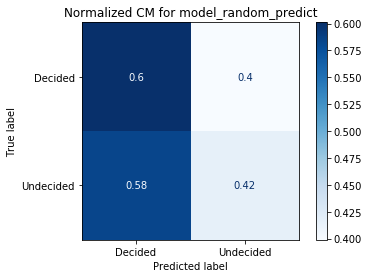

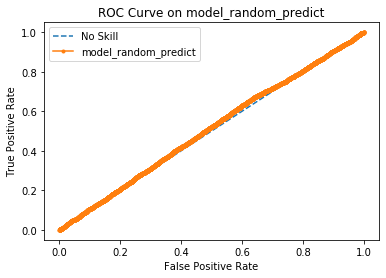

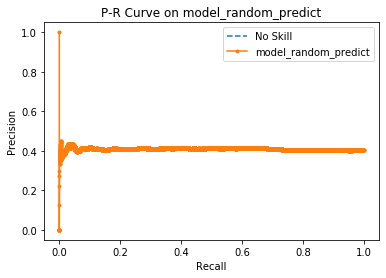

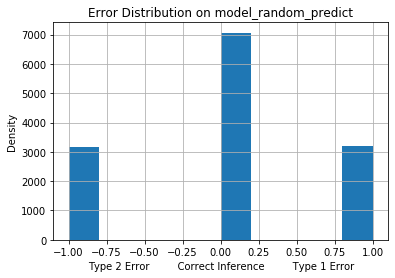

In [24]:
y_label = 'pre_score_undecided_wide'

y_true = analysis_df[baseline_range][y_label]

y_pred_col = 'model_random_predict'
y_prob_col = 'model_random_prob'

y_pred = analysis_df[baseline_range][y_pred_col]
y_prob = analysis_df[baseline_range][y_prob_col]

score_model(y_true, y_pred, y_prob, y_pred_col)
plot_confusion_matrix(y_true, y_pred, y_pred_col)
plt.show()
plot_roc_curve(y_true, y_pred, y_prob, y_pred_col)    
plt.show()
plot_pr_curve(y_true, y_pred, y_prob, y_pred_col)  
plt.show()
plot_error_distribution(y_true, y_pred, y_pred_col)
plt.show()
analysis_df['error_' + y_pred_col] = y_pred - y_true

# Model Scores and Error Results

In [25]:
y_label = 'pre_score_undecided_wide'
baseline_label = 'model_random'

#for m in models.values():
#      plot_model_info(m, analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)
keys = list(models.keys())


classification accuracy: 0.5686
misclassification rate: 0.4314
sensitivity (true positive rate) aka recall: 0.3688
specificity: 0.6971
false positive rate: 0.3029
precision: 0.4281
f1 score: 0.4009
roc auc: 0.5526
cohens kappa: 0.0678
mcc: 0.0684
mse: 0.4314
confusion:
[[6020 2616]
 [3507 2049]]




classification accuracy: 0.544
misclassification rate: 0.456
sensitivity (true positive rate) aka recall: 0.4638
specificity: 0.601
false positive rate: 0.399
precision: 0.4489
f1 score: 0.4578
roc auc: 0.5446
cohens kappa: 0.0645
mcc: 0.0646
mse: 0.456
confusion:
[[4793 3182]
 [3035 2625]]



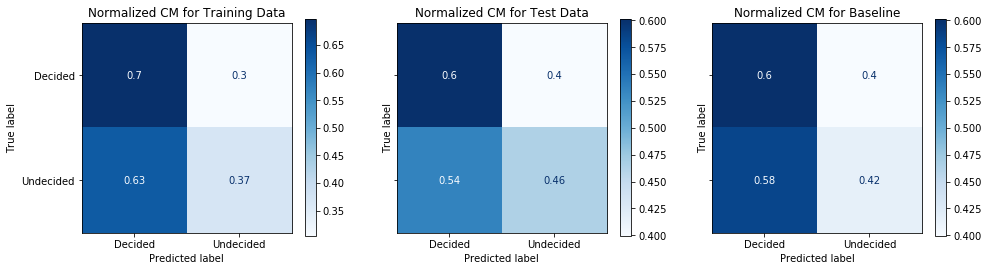

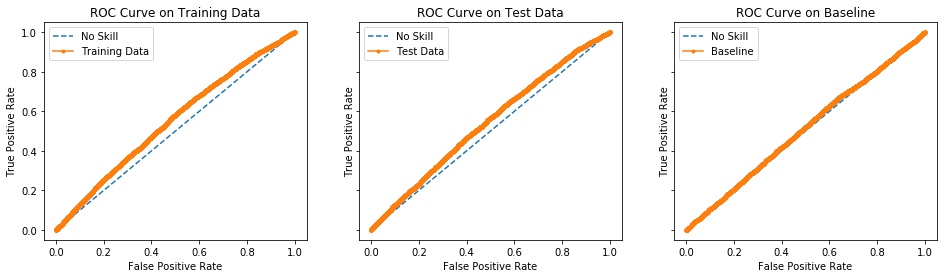

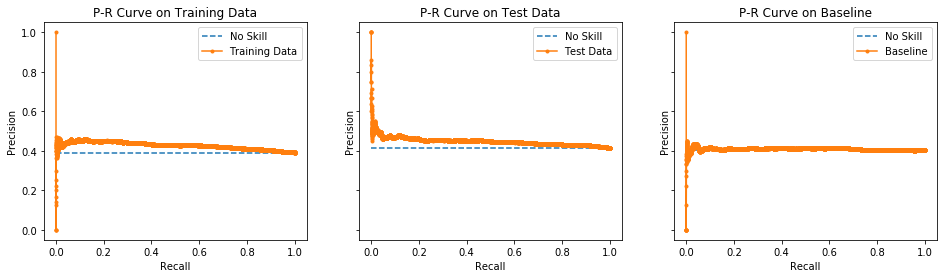

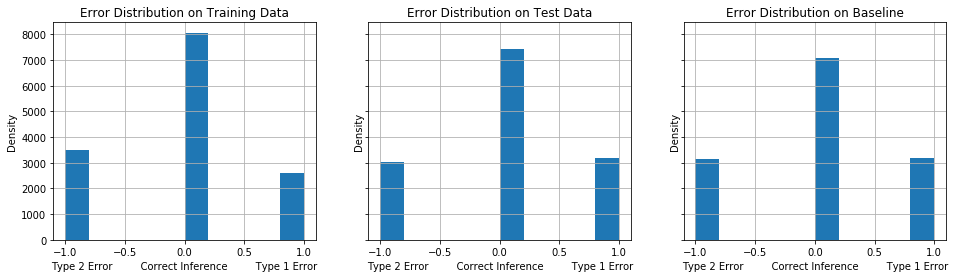

,coef,abs_coef
license_score,1.106267,1.106267
medicaid_score,0.321346,0.321346
gun_control_score,-0.302286,0.302286
climate_change_score,-0.217405,0.217405
state_NC,-0.195370,0.195370
ideology_score,0.194210,0.194210
labor_union_support_score,0.182081,0.182081
universalism_score,-0.174148,0.174148
anti_trump_activism_score,0.157977,0.157977
state_AZ,0.143005,0.143005


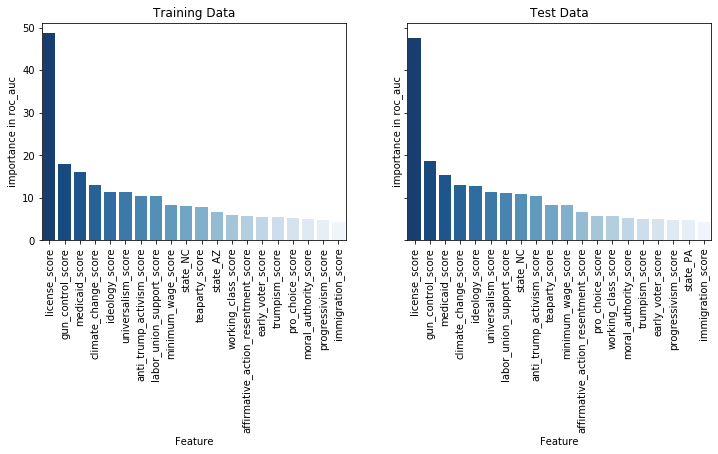

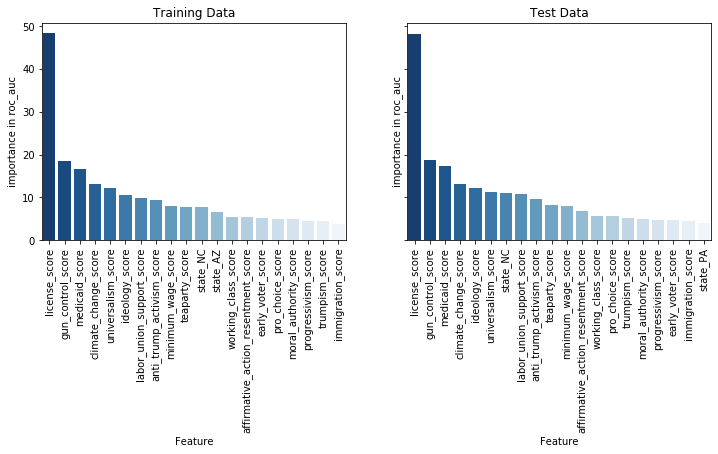

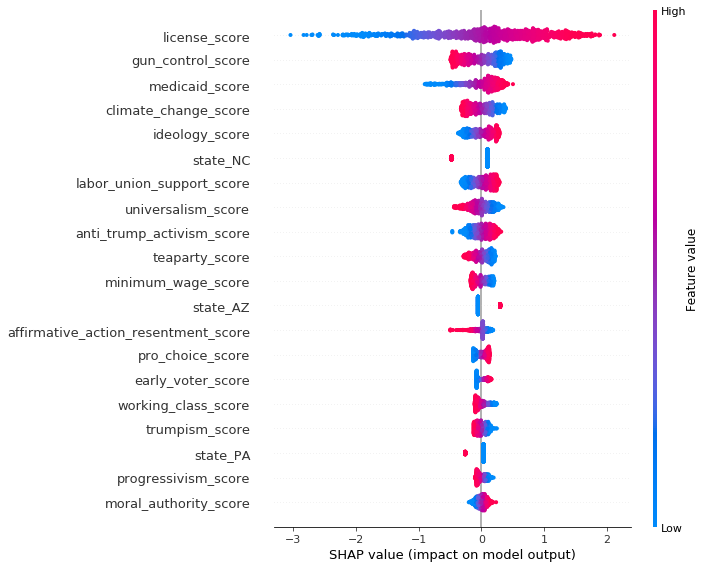

In [26]:
plot_model_info(models[keys[0]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.5794
misclassification rate: 0.4206
sensitivity (true positive rate) aka recall: 0.3866
specificity: 0.7035
false positive rate: 0.2965
precision: 0.4362
f1 score: 0.4185
roc auc: 0.5636
cohens kappa: 0.0926
mcc: 0.0934
mse: 0.4206
confusion:
[[6075 2561]
 [3408 2148]]




classification accuracy: 0.5441
misclassification rate: 0.4559
sensitivity (true positive rate) aka recall: 0.4885
specificity: 0.5836
false positive rate: 0.4164
precision: 0.4532
f1 score: 0.4708
roc auc: 0.5521
cohens kappa: 0.0713
mcc: 0.0715
mse: 0.4559
confusion:
[[4654 3321]
 [2895 2765]]



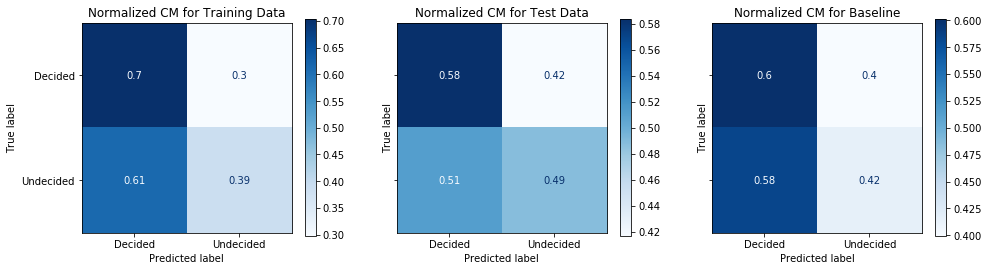

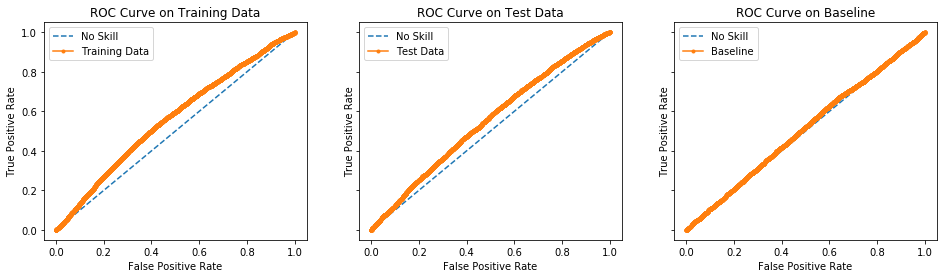

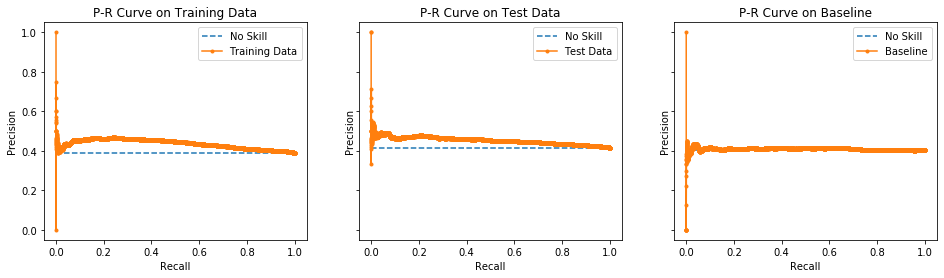

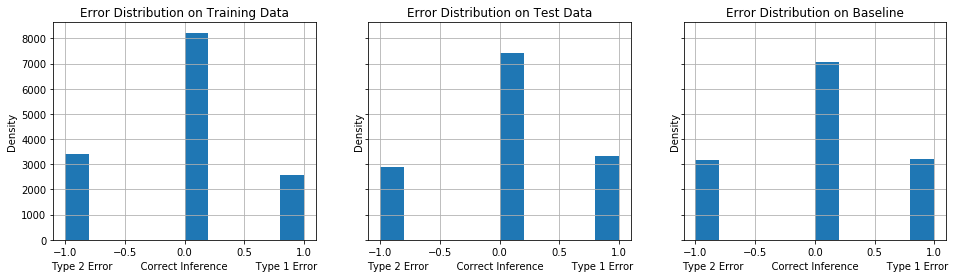

,importance
license_score,0.176620
medicaid_score,0.112247
teaparty_score,0.079502
labor_union_support_score,0.068773
immigration_score,0.061171
gun_control_score,0.044569
minimum_wage_score,0.040352
pro_choice_score,0.036642
affirmative_action_resentment_score,0.035572
ideology_score,0.032240


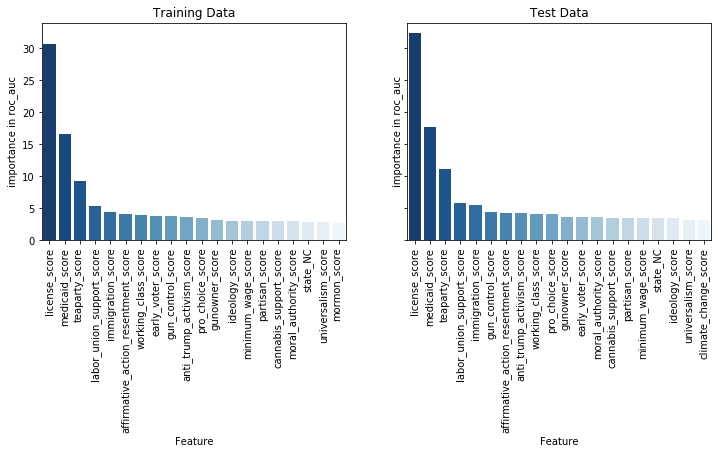

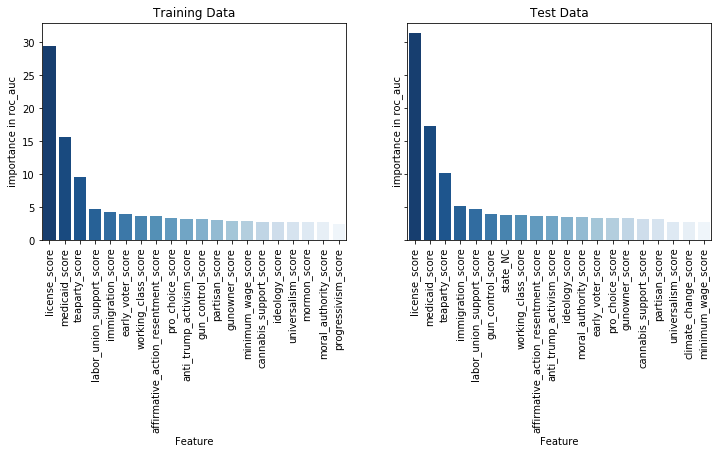

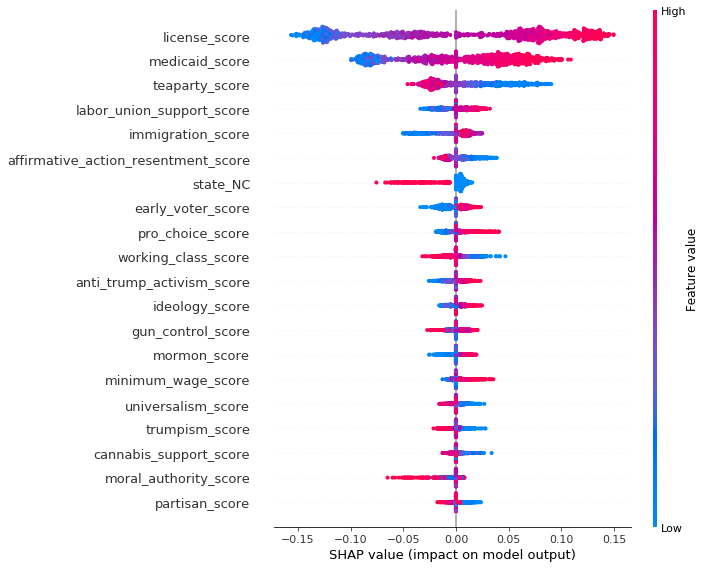

In [27]:
plot_model_info(models[keys[1]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.5709
misclassification rate: 0.4291
sensitivity (true positive rate) aka recall: 0.3481
specificity: 0.7142
false positive rate: 0.2858
precision: 0.4315
f1 score: 0.3884
roc auc: 0.5531
cohens kappa: 0.0647
mcc: 0.0657
mse: 0.4291
confusion:
[[6168 2468]
 [3622 1934]]




classification accuracy: 0.5452
misclassification rate: 0.4548
sensitivity (true positive rate) aka recall: 0.4336
specificity: 0.6245
false positive rate: 0.3755
precision: 0.4433
f1 score: 0.4418
roc auc: 0.5413
cohens kappa: 0.0583
mcc: 0.0584
mse: 0.4548
confusion:
[[4980 2995]
 [3206 2454]]



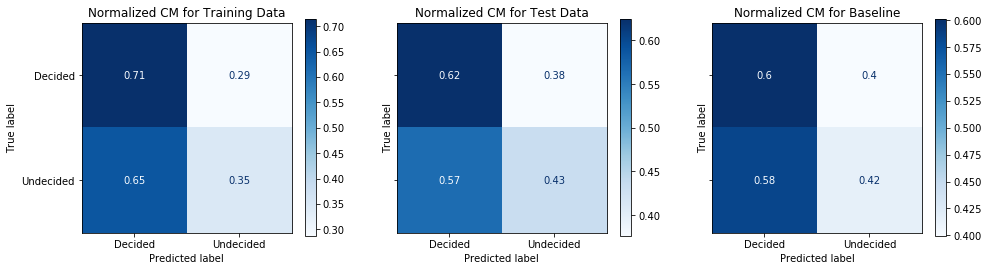

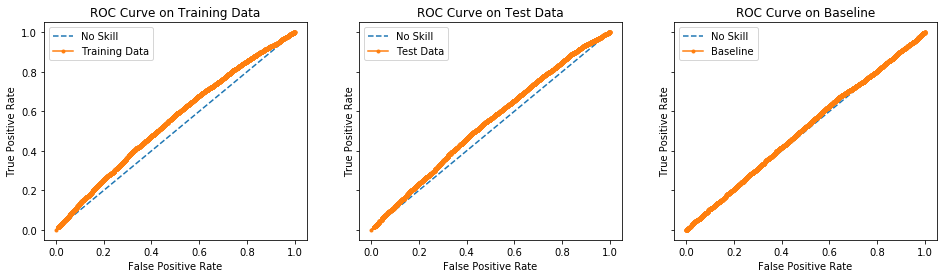

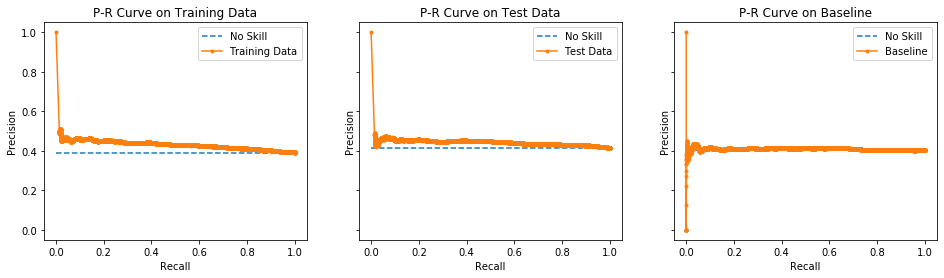

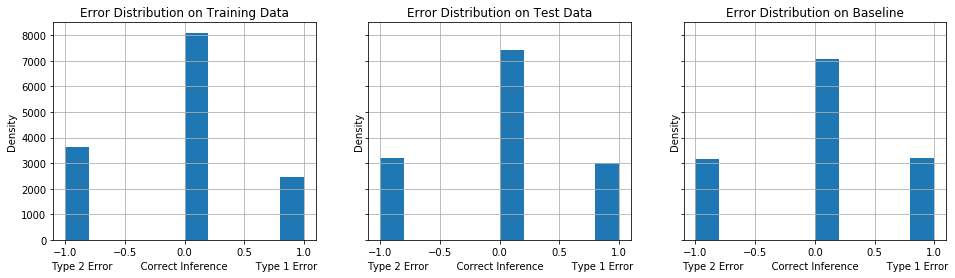

,coef,abs_coef
license_score,0.990594,0.990594
gun_control_score,-0.337233,0.337233
climate_change_score,-0.231913,0.231913
teaparty_score,-0.212704,0.212704
medicaid_score,0.184499,0.184499
affirmative_action_resentment_score,-0.183677,0.183677
trumpism_score,-0.175983,0.175983
pro_choice_score,0.161856,0.161856
universalism_score,-0.154661,0.154661
anti_trump_activism_score,0.147653,0.147653


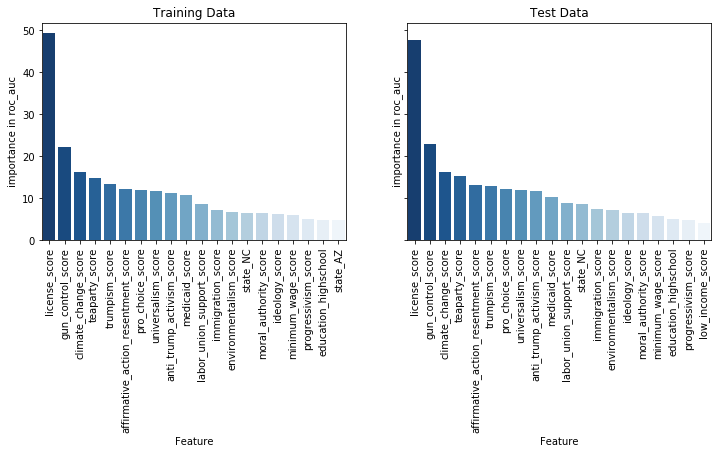

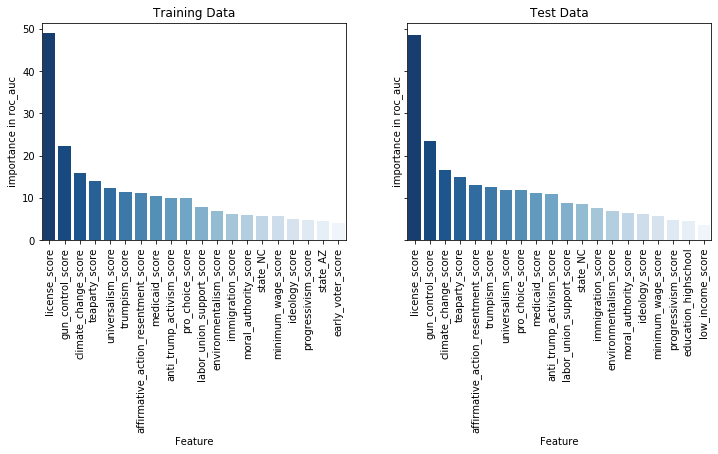

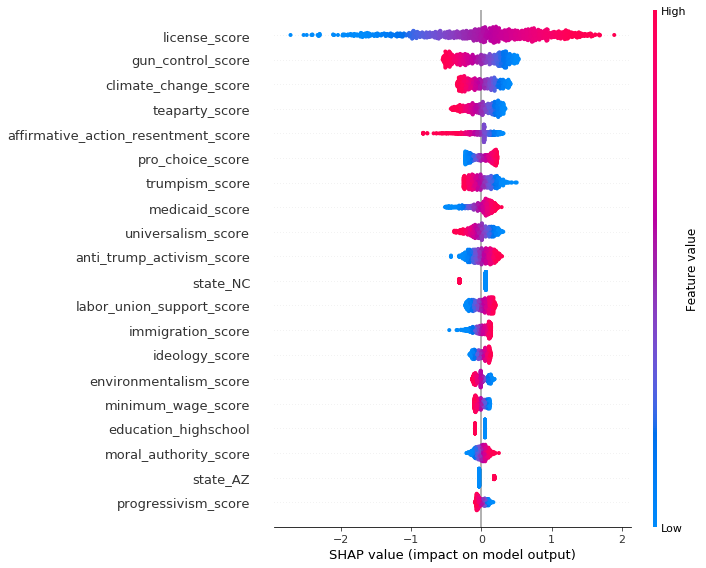

In [28]:
plot_model_info(models[keys[2]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.5642
misclassification rate: 0.4358
sensitivity (true positive rate) aka recall: 0.4141
specificity: 0.6607
false positive rate: 0.3393
precision: 0.4331
f1 score: 0.4266
roc auc: 0.5597
cohens kappa: 0.0757
mcc: 0.0757
mse: 0.4358
confusion:
[[5706 2930]
 [3255 2301]]




classification accuracy: 0.5364
misclassification rate: 0.4636
sensitivity (true positive rate) aka recall: 0.4827
specificity: 0.5745
false positive rate: 0.4255
precision: 0.4418
f1 score: 0.4636
roc auc: 0.5437
cohens kappa: 0.0566
mcc: 0.0567
mse: 0.4636
confusion:
[[4582 3393]
 [2928 2732]]



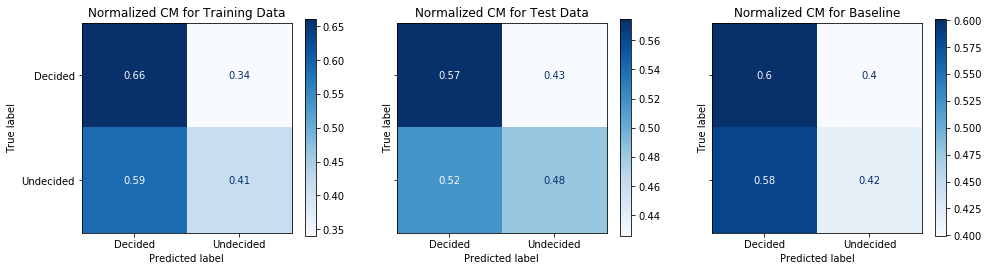

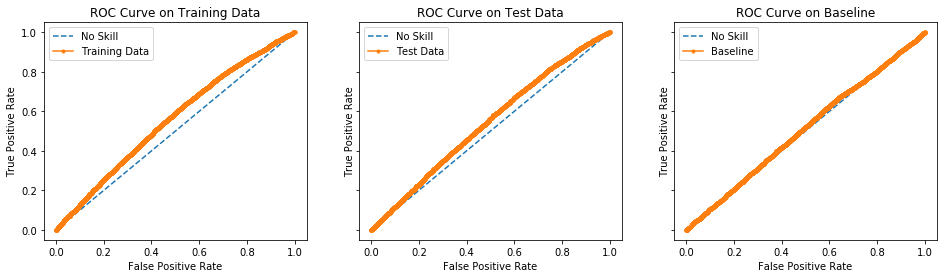

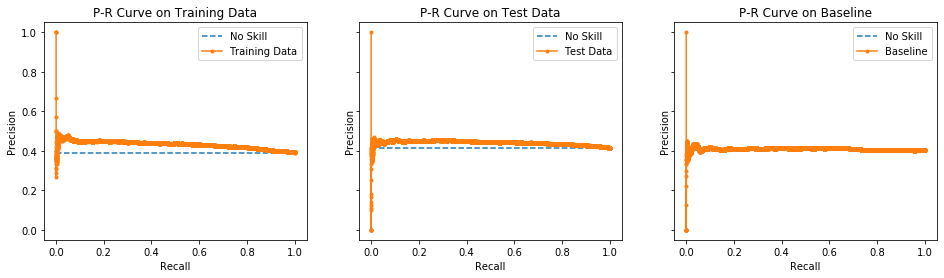

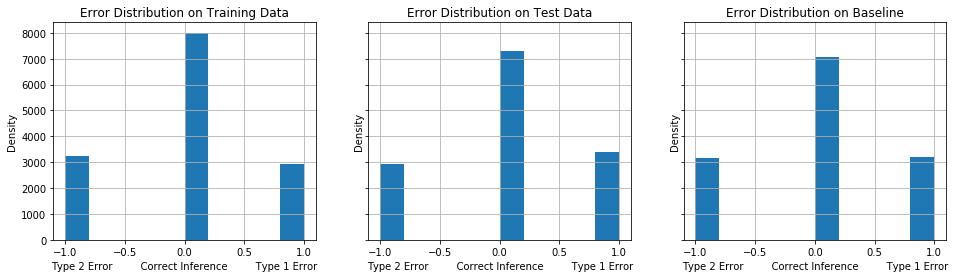

,coef,abs_coef
age_sq,-1.262831,1.262831
license_score,1.174132,1.174132
age,0.861377,0.861377
gun_control_score,-0.371343,0.371343
children_present_score,-0.280988,0.280988
election_turnout_score,0.234469,0.234469
ideology_score,0.233754,0.233754
hh_num_dems,0.172315,0.172315
vote_party_2012_O,0.170691,0.170691
partisan_score,-0.167282,0.167282


,coef,abs_coef
license_score,-1.024734,1.024734
age_sq,0.266622,0.266622
gun_control_score,0.264997,0.264997
universalism_score,0.195457,0.195457
moral_purity_score,-0.163124,0.163124
vote_party_2012_O,-0.162455,0.162455
ideology_score,-0.158606,0.158606
religious_freedom_score,0.145638,0.145638
pr_african_descent,-0.143198,0.143198
age,0.141736,0.141736


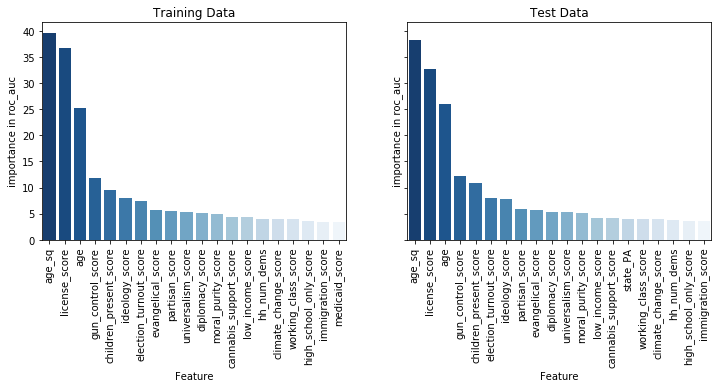

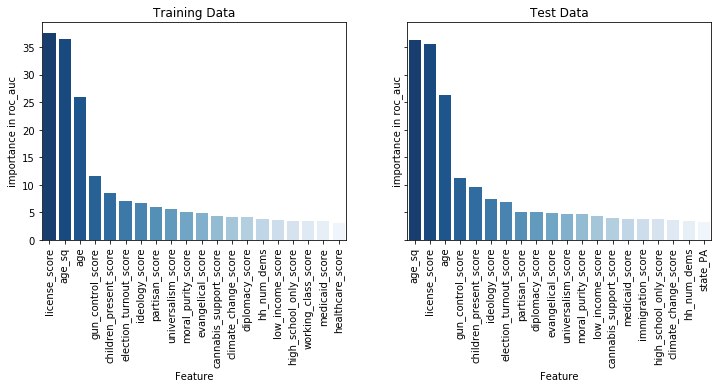

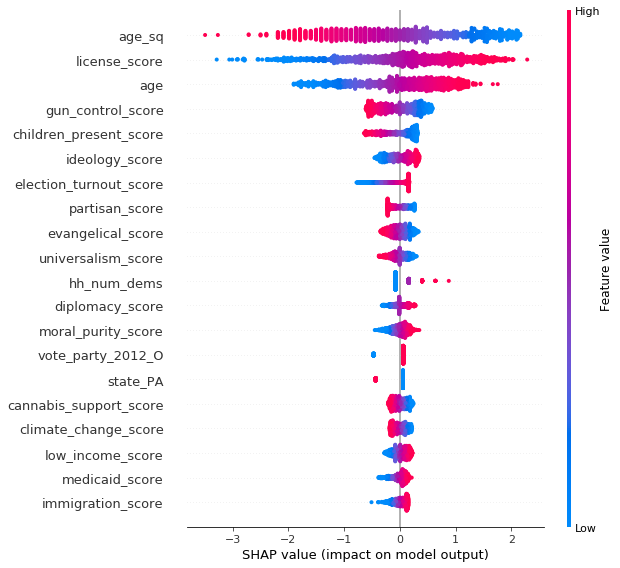

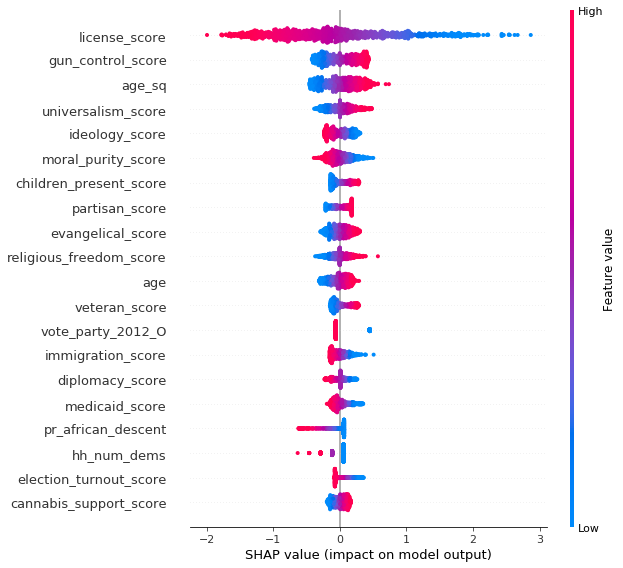

In [29]:
plot_model_info(models[keys[3]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.6163
misclassification rate: 0.3837
sensitivity (true positive rate) aka recall: 0.3335
specificity: 0.7983
false positive rate: 0.2017
precision: 0.4934
f1 score: 0.405
roc auc: 0.6068
cohens kappa: 0.1407
mcc: 0.1479
mse: 0.3837
confusion:
[[6894 1742]
 [3703 1853]]




classification accuracy: 0.5765
misclassification rate: 0.4235
sensitivity (true positive rate) aka recall: 0.3371
specificity: 0.7465
false positive rate: 0.2535
precision: 0.4754
f1 score: 0.3979
roc auc: 0.5708
cohens kappa: 0.0874
mcc: 0.0909
mse: 0.4235
confusion:
[[5953 2022]
 [3752 1908]]



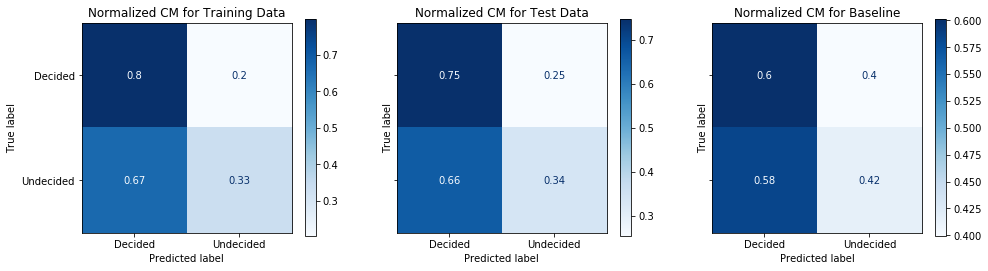

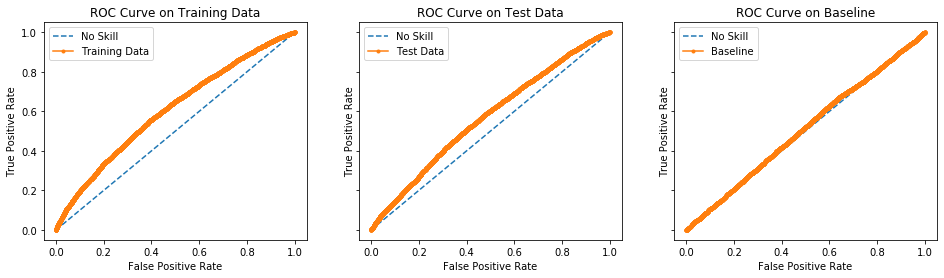

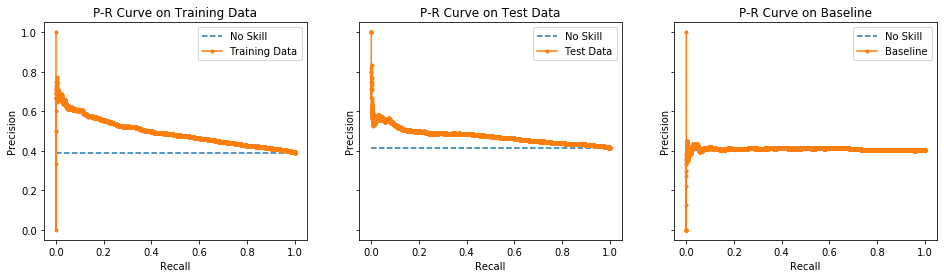

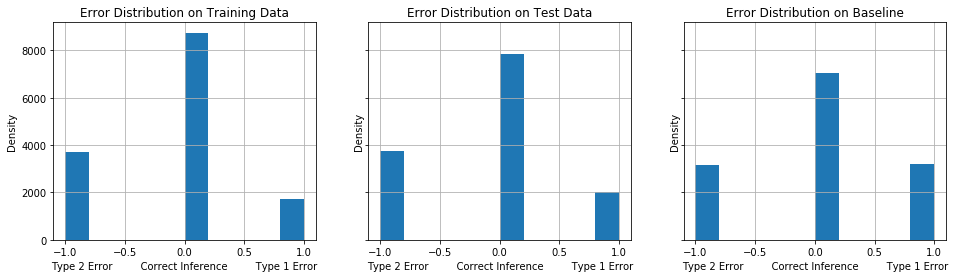

,coef,abs_coef
license_score,-0.738964,0.738964
age_sq,0.316484,0.316484
gun_control_score,0.305884,0.305884
state_NC,0.177115,0.177115
evangelical_score,0.144076,0.144076
labor_union_support_score,-0.138145,0.138145
moral_purity_score,-0.116315,0.116315
vote_party_2012_O,-0.111493,0.111493
trumpism_score,0.103825,0.103825
moral_authority_score,-0.096848,0.096848


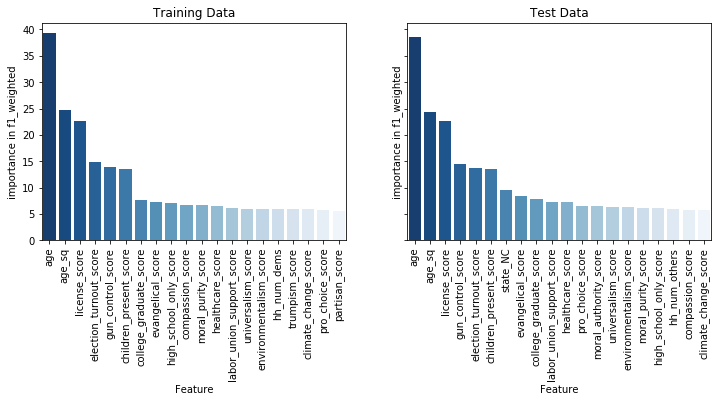

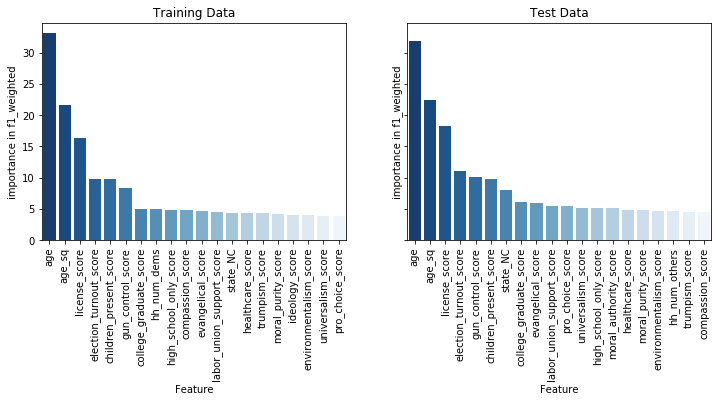

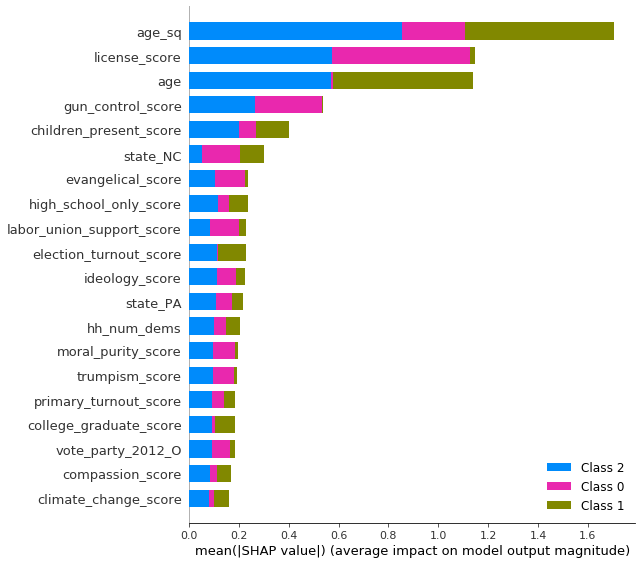

In [30]:
plot_model_info(models[keys[4]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.5991
misclassification rate: 0.4009
sensitivity (true positive rate) aka recall: 0.5347
specificity: 0.6405
false positive rate: 0.3595
precision: 0.4962
f1 score: 0.5108
roc auc: 0.6157
cohens kappa: 0.1723
mcc: 0.1728
mse: 0.4009
confusion:
[[5531 3105]
 [2585 2971]]




classification accuracy: 0.5611
misclassification rate: 0.4389
sensitivity (true positive rate) aka recall: 0.5249
specificity: 0.5867
false positive rate: 0.4133
precision: 0.4871
f1 score: 0.4982
roc auc: 0.5731
cohens kappa: 0.1099
mcc: 0.1104
mse: 0.4389
confusion:
[[4679 3296]
 [2689 2971]]



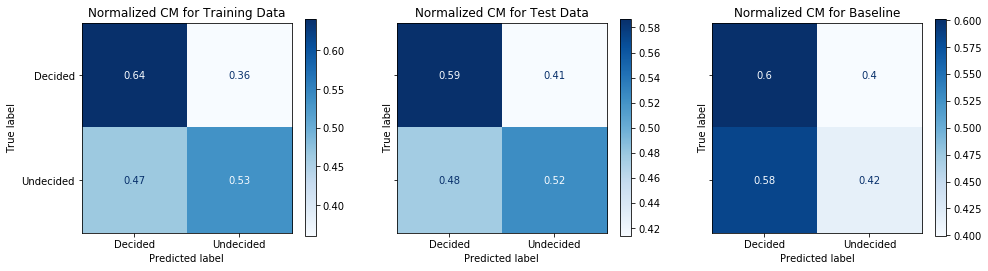

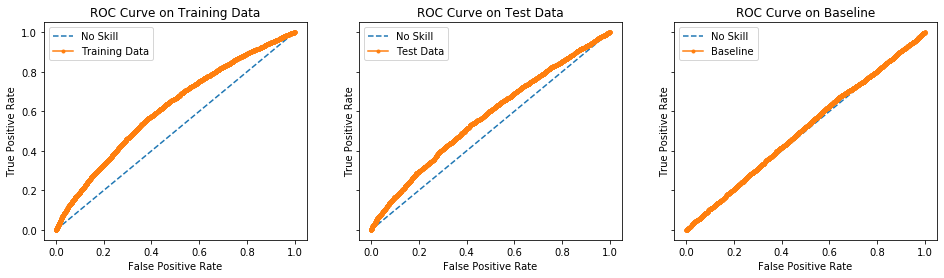

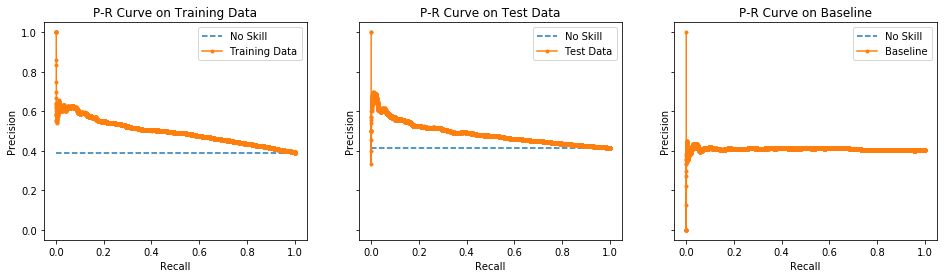

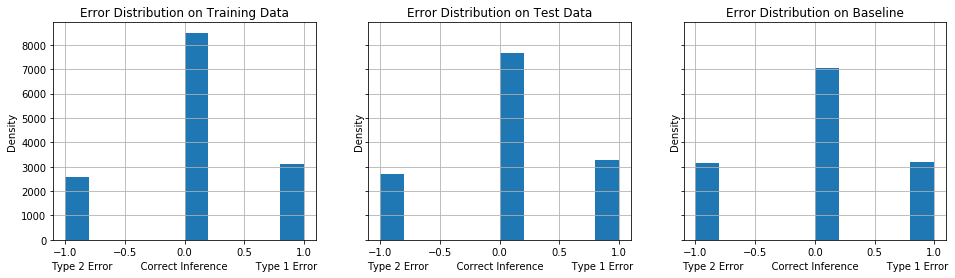

,coef,abs_coef
age_sq,0.645572,0.645572
age,-0.638859,0.638859
labor_union_support_score,-0.222364,0.222364
election_turnout_score,-0.157908,0.157908
state_PA,0.109754,0.109754
gender_female,-0.107647,0.107647
incomeXage,-0.102579,0.102579
state_CO,0.096006,0.096006
pr_asian_descent,0.084733,0.084733
pro_choice_score,0.082990,0.082990


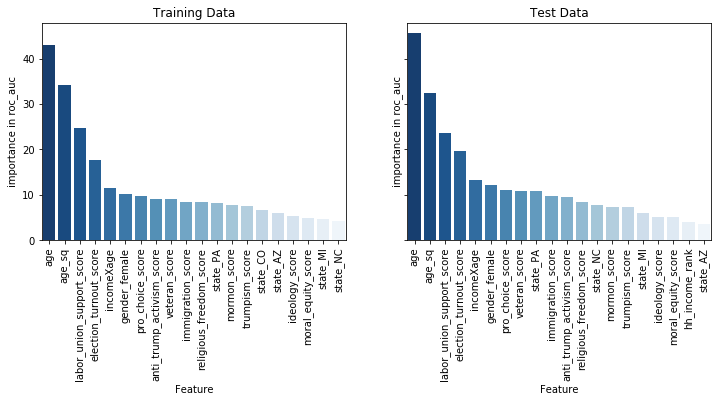

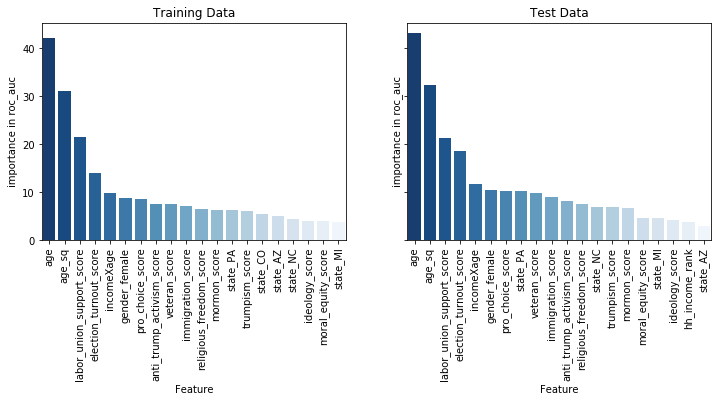

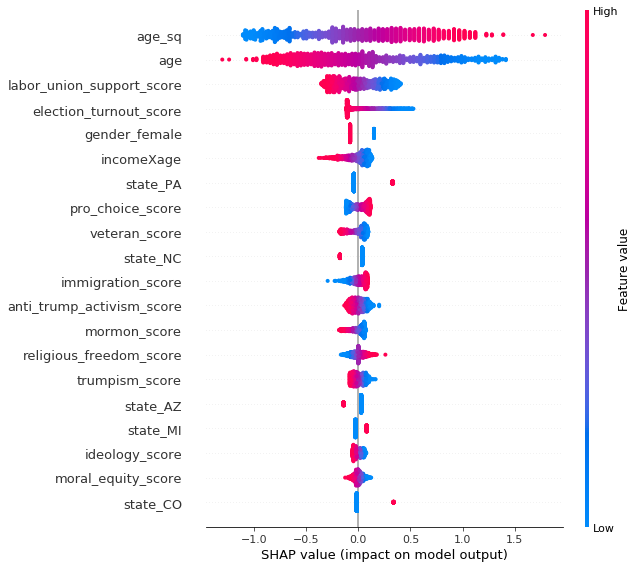

In [31]:
plot_model_info(models[keys[5]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.6955
misclassification rate: 0.3045
sensitivity (true positive rate) aka recall: 0.6731
specificity: 0.7098
false positive rate: 0.2902
precision: 0.6685
f1 score: 0.6338
roc auc: 0.766
cohens kappa: 0.3747
mcc: 0.3765
mse: 0.3045
confusion:
[[6130 2506]
 [1816 3740]]




classification accuracy: 0.5666
misclassification rate: 0.4334
sensitivity (true positive rate) aka recall: 0.5608
specificity: 0.5707
false positive rate: 0.4293
precision: 0.4939
f1 score: 0.5179
roc auc: 0.5878
cohens kappa: 0.1283
mcc: 0.1296
mse: 0.4334
confusion:
[[4551 3424]
 [2486 3174]]



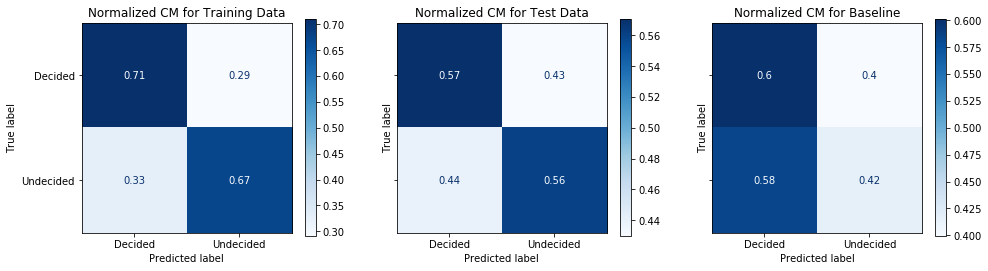

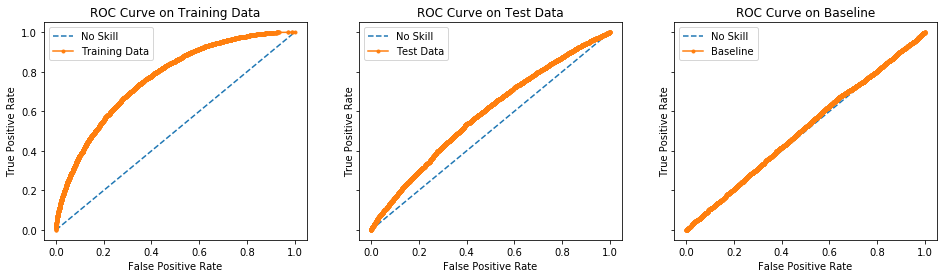

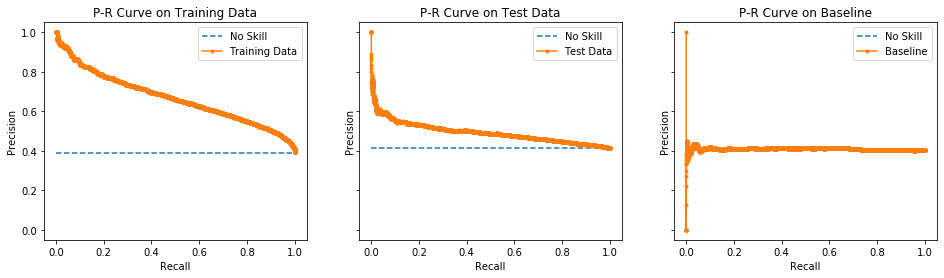

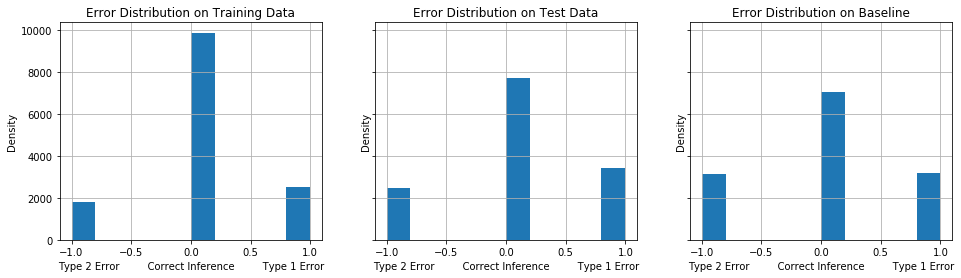

,importance
election_turnout_score,0.124504
pr_asian_descent,0.057100
ideology_score,0.047398
anti_trump_activism_score,0.046427
age,0.046333
immigration_score,0.045358
labor_union_support_score,0.044631
age_sq,0.044379
mormon_score,0.043219
incomeXage,0.043194


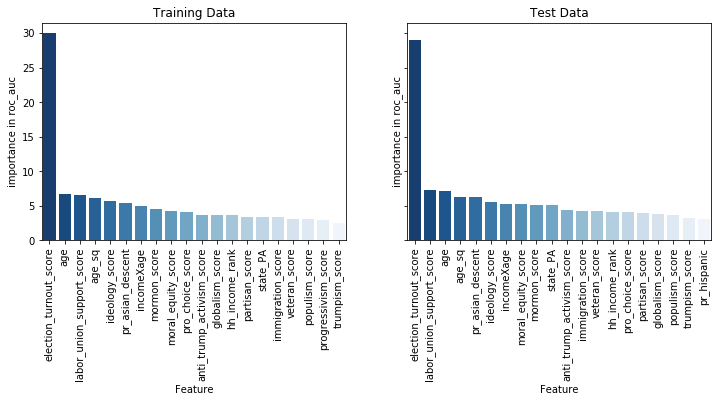

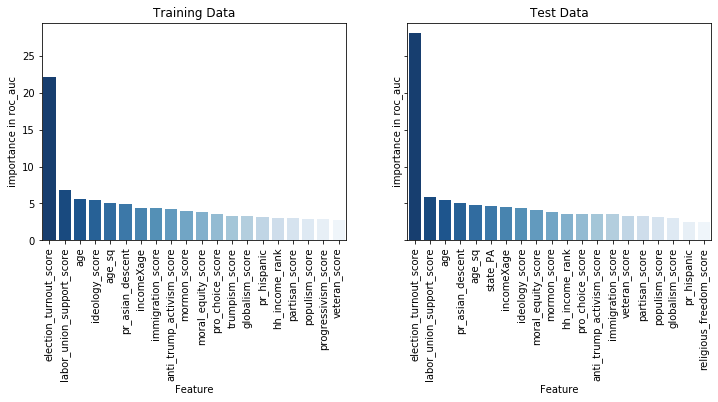

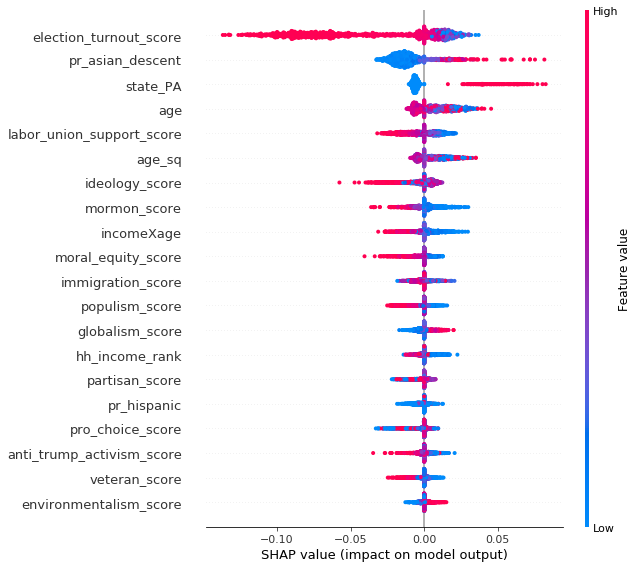

In [32]:
plot_model_info(models[keys[6]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.5994
misclassification rate: 0.4006
sensitivity (true positive rate) aka recall: 0.8558
specificity: 0.4343
false positive rate: 0.5657
precision: 0.6045
f1 score: 0.6258
roc auc: 0.7189
cohens kappa: 0.2565
mcc: 0.3034
mse: 0.4006
confusion:
[[3751 4885]
 [ 801 4755]]




classification accuracy: 0.5045
misclassification rate: 0.4955
sensitivity (true positive rate) aka recall: 0.8044
specificity: 0.2917
false positive rate: 0.7083
precision: 0.49
f1 score: 0.5741
roc auc: 0.5851
cohens kappa: 0.0861
mcc: 0.1091
mse: 0.4955
confusion:
[[2326 5649]
 [1107 4553]]



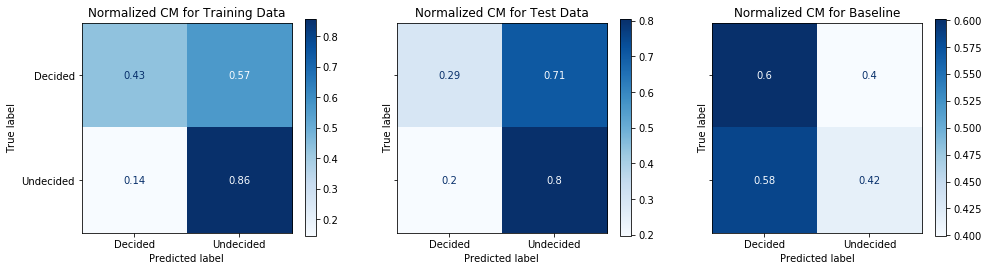

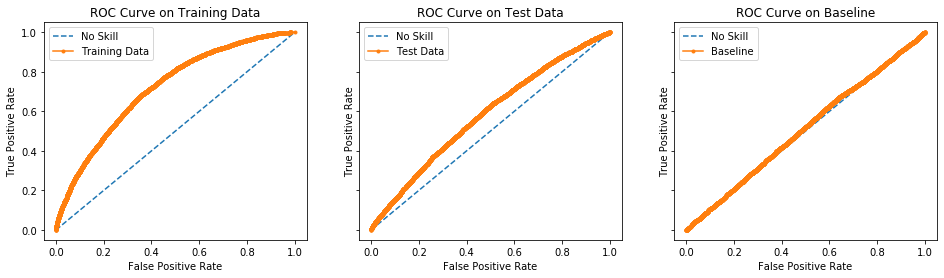

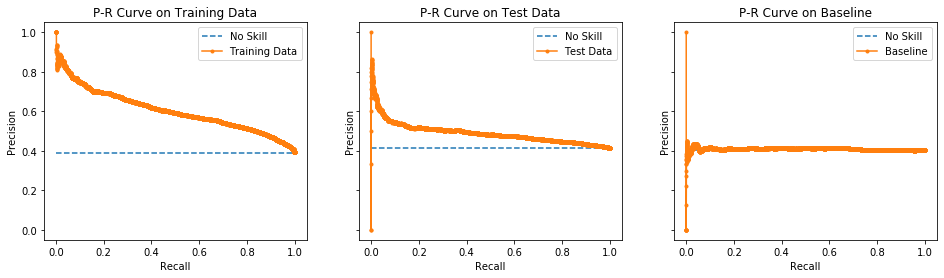

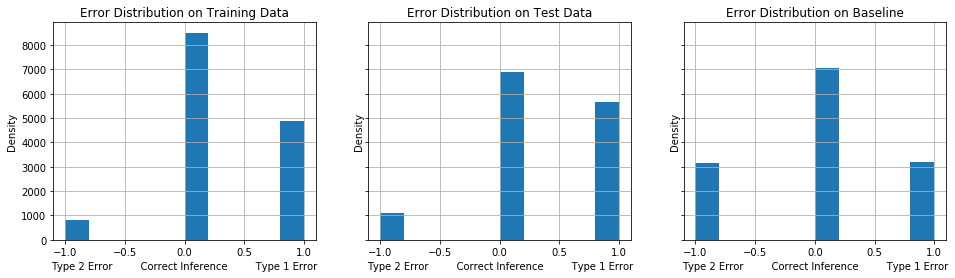

,importance
election_turnout_score,0.071302
state_PA,0.062196
state_CO,0.057771
age,0.041540
age_sq,0.039332
state_NH,0.035319
state_AZ,0.034892
pr_asian_descent,0.032487
ideology_score,0.030460
labor_union_support_score,0.030279


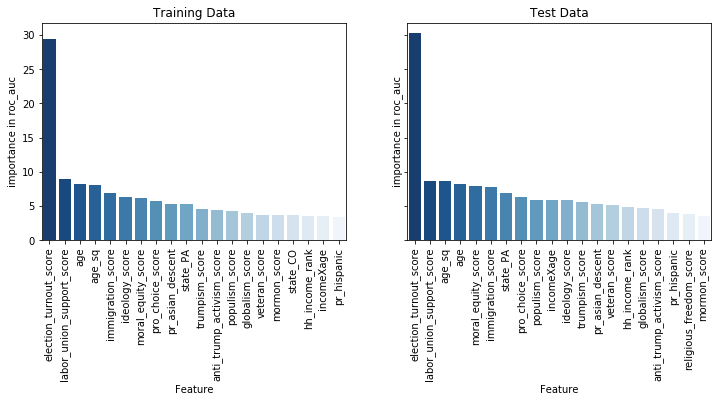

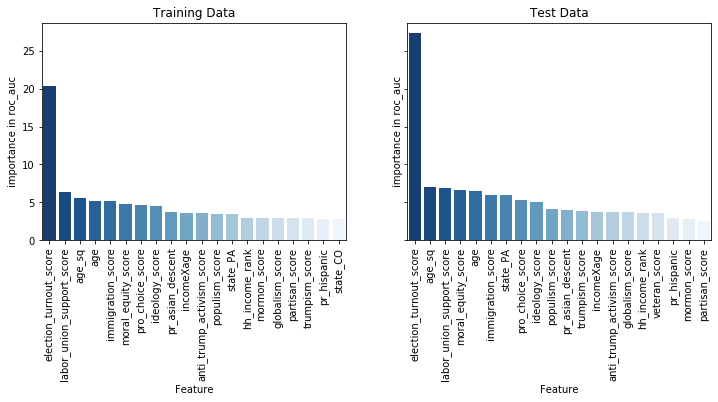

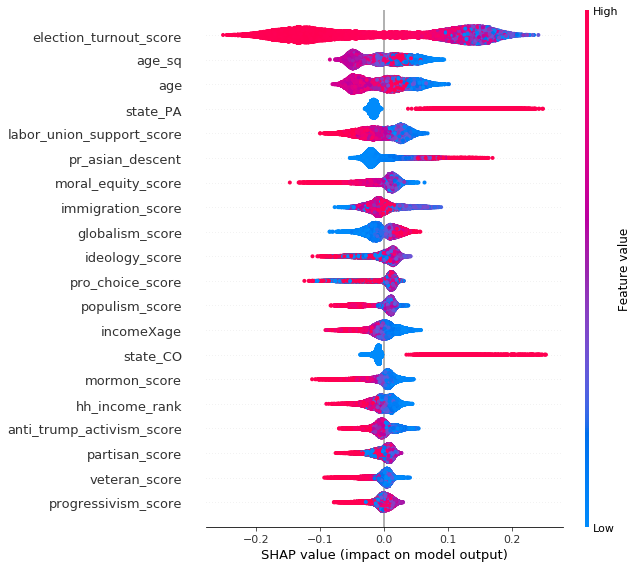

In [33]:
plot_model_info(models[keys[7]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.6271
misclassification rate: 0.3729
sensitivity (true positive rate) aka recall: 0.6118
specificity: 0.637
false positive rate: 0.363
precision: 0.5544
f1 score: 0.5623
roc auc: 0.6725
cohens kappa: 0.2412
mcc: 0.2436
mse: 0.3729
confusion:
[[5501 3135]
 [2157 3399]]




classification accuracy: 0.5561
misclassification rate: 0.4439
sensitivity (true positive rate) aka recall: 0.5822
specificity: 0.5376
false positive rate: 0.4624
precision: 0.4929
f1 score: 0.5212
roc auc: 0.585
cohens kappa: 0.1158
mcc: 0.118
mse: 0.4439
confusion:
[[4287 3688]
 [2365 3295]]



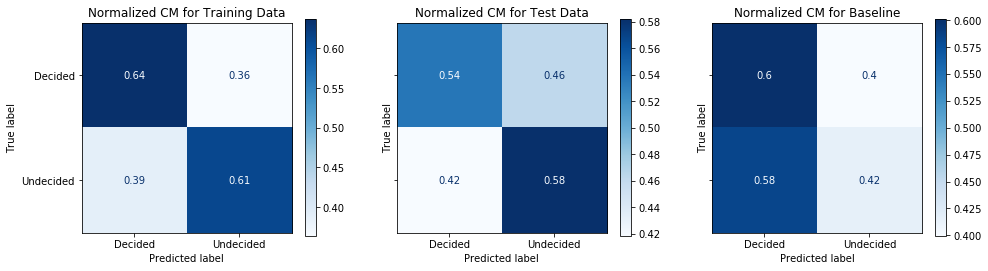

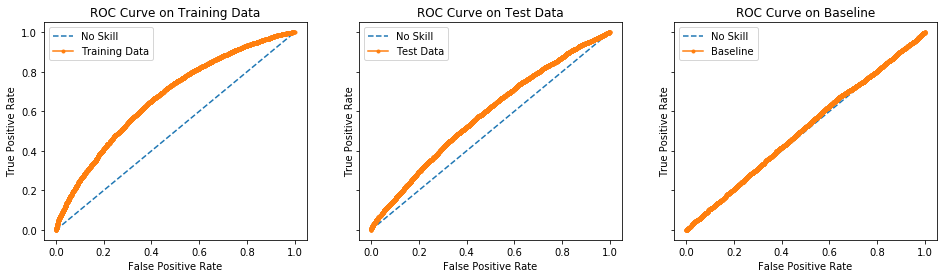

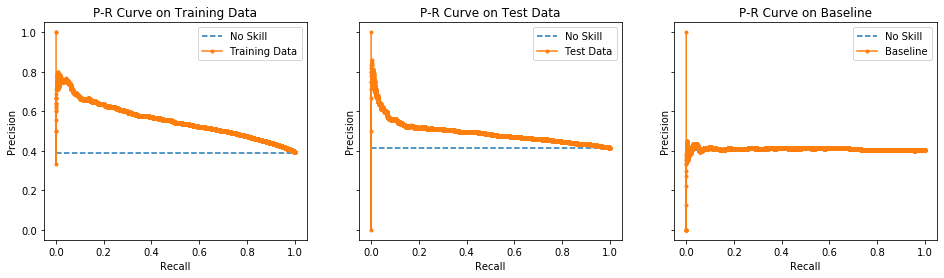

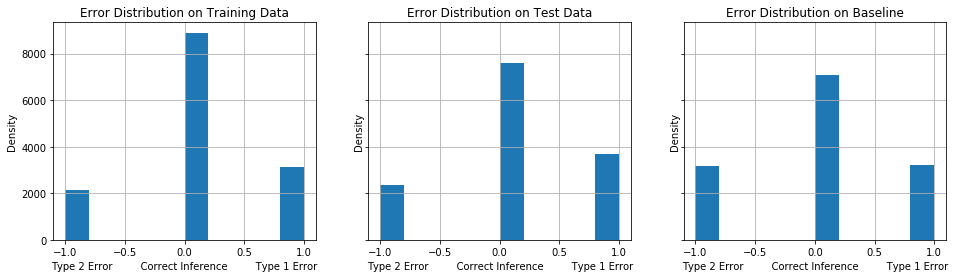

,importance
election_turnout_score,134
age_sq,125
moral_equity_score,98
ideology_score,96
pro_choice_score,91
labor_union_support_score,86
pr_asian_descent,84
immigration_score,82
mormon_score,82
partisan_score,78


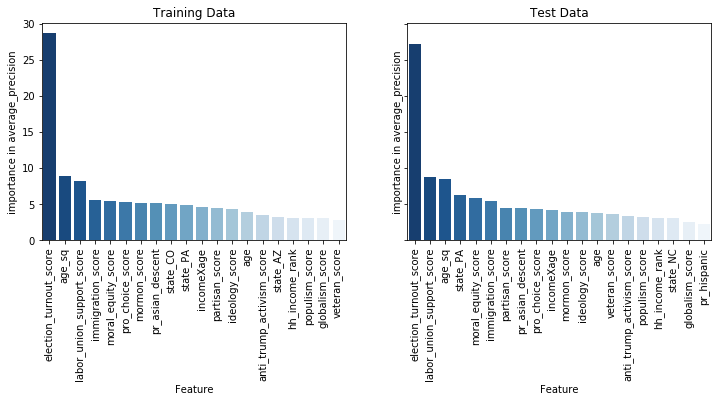

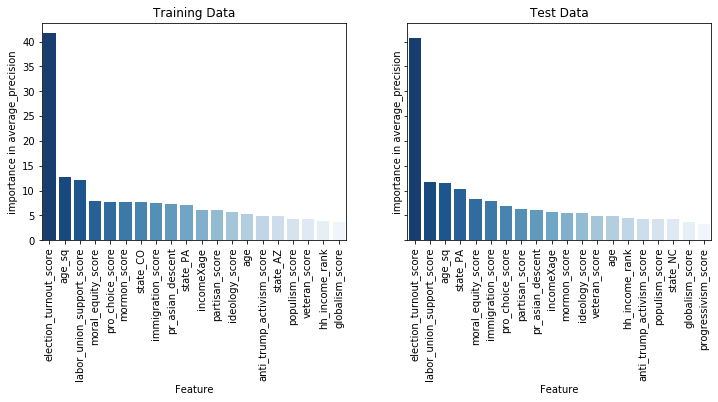

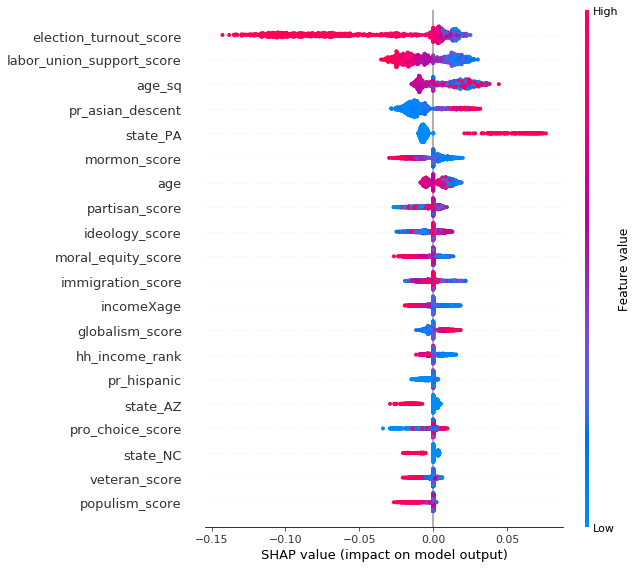

In [34]:
plot_model_info(models[keys[8]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.5946
misclassification rate: 0.4054
sensitivity (true positive rate) aka recall: 0.5146
specificity: 0.6461
false positive rate: 0.3539
precision: 0.5007
f1 score: 0.4985
roc auc: 0.6176
cohens kappa: 0.1589
mcc: 0.1591
mse: 0.4054
confusion:
[[5580 3056]
 [2697 2859]]




classification accuracy: 0.5594
misclassification rate: 0.4406
sensitivity (true positive rate) aka recall: 0.5207
specificity: 0.5868
false positive rate: 0.4132
precision: 0.4847
f1 score: 0.4952
roc auc: 0.5745
cohens kappa: 0.1059
mcc: 0.1063
mse: 0.4406
confusion:
[[4680 3295]
 [2713 2947]]



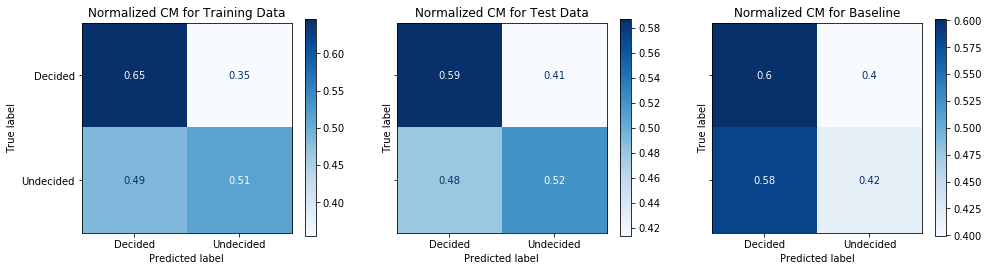

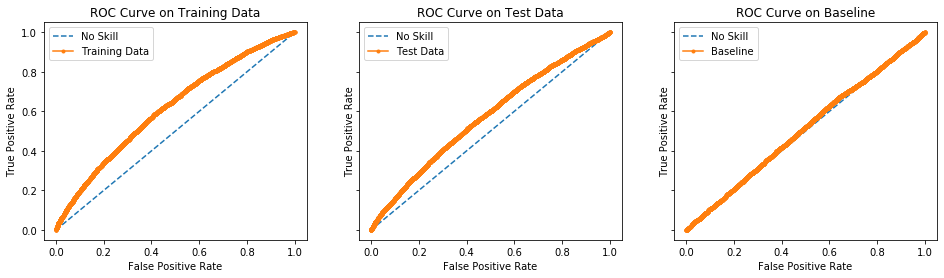

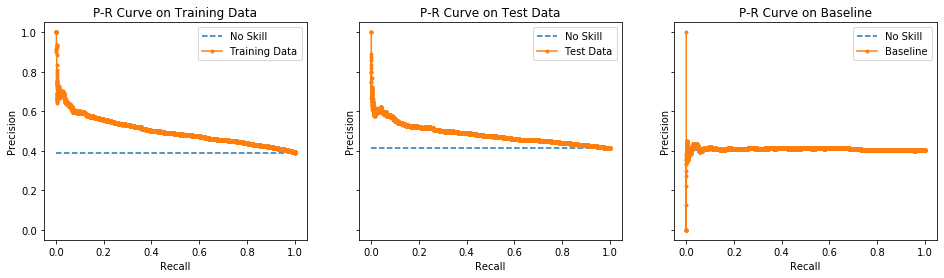

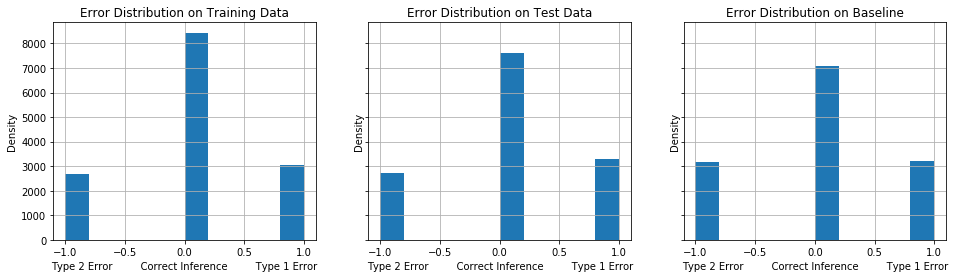

,coef,abs_coef
state_PA,0.158896,0.158896
election_turnout_score,-0.151556,0.151556
teaparty_score,0.129815,0.129815
state_CO,0.119895,0.119895
hh_num_dems,-0.096484,0.096484
children_present_score,0.080530,0.080530
hh_num_others,0.079056,0.079056
incomeXage,-0.078079,0.078079
govt_privacy_score,-0.072096,0.072096
pr_european_descent,-0.063673,0.063673


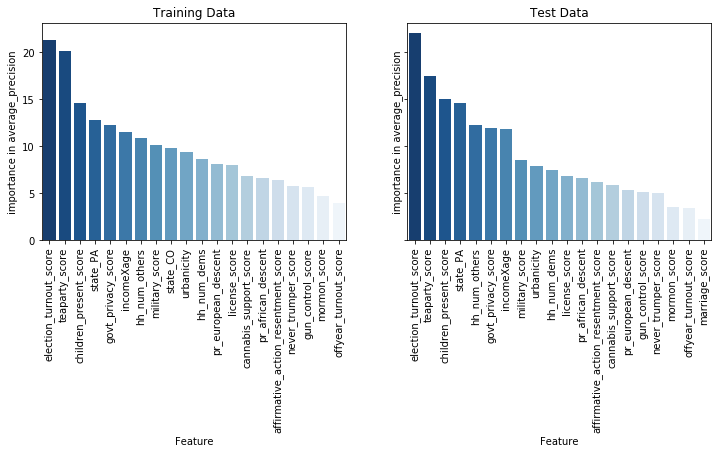

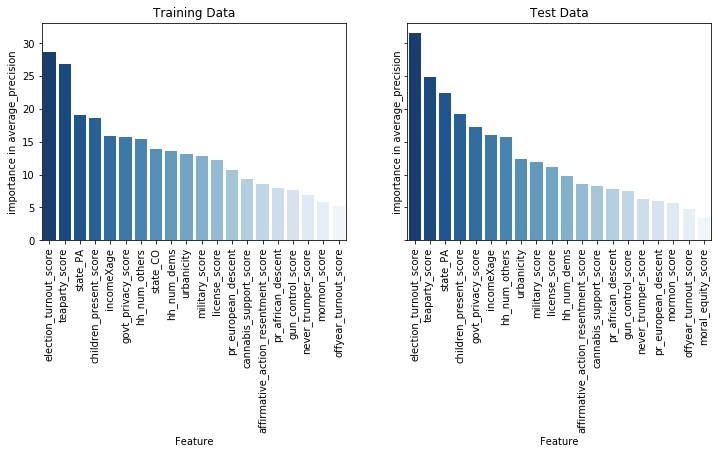

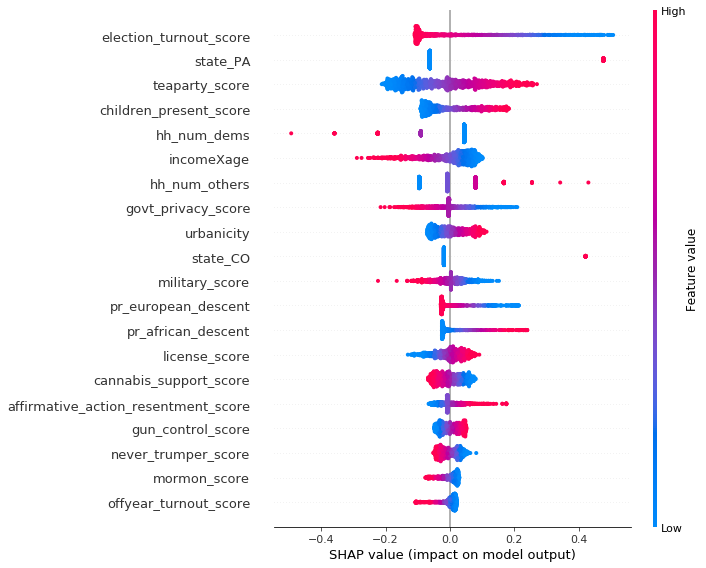

In [35]:
plot_model_info(models[keys[9]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)


classification accuracy: 0.6425
misclassification rate: 0.3575
sensitivity (true positive rate) aka recall: 0.637
specificity: 0.6461
false positive rate: 0.3539
precision: 0.5827
f1 score: 0.5825
roc auc: 0.6969
cohens kappa: 0.274
mcc: 0.277
mse: 0.3575
confusion:
[[5580 3056]
 [2017 3539]]




classification accuracy: 0.5642
misclassification rate: 0.4358
sensitivity (true positive rate) aka recall: 0.5965
specificity: 0.5413
false positive rate: 0.4587
precision: 0.4962
f1 score: 0.5319
roc auc: 0.5945
cohens kappa: 0.1331
mcc: 0.1359
mse: 0.4358
confusion:
[[4317 3658]
 [2284 3376]]



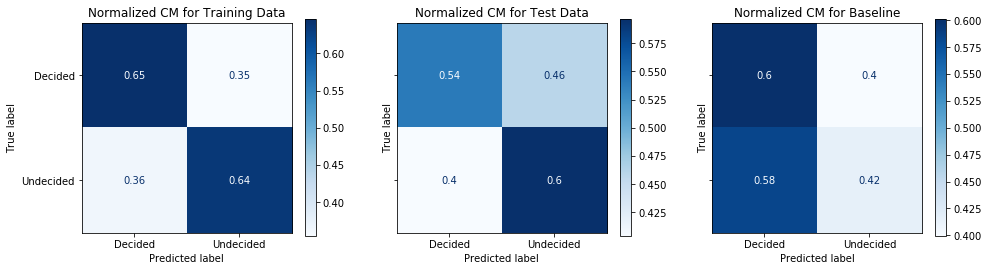

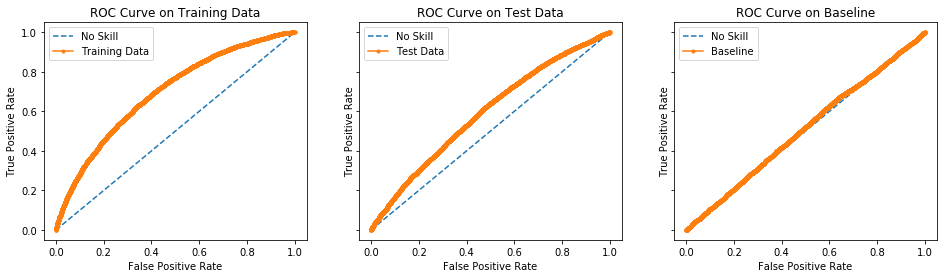

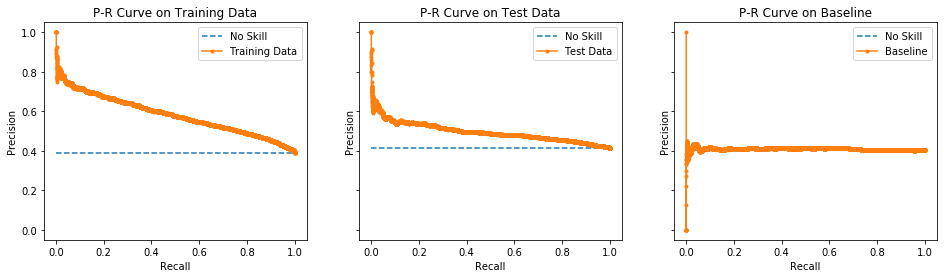

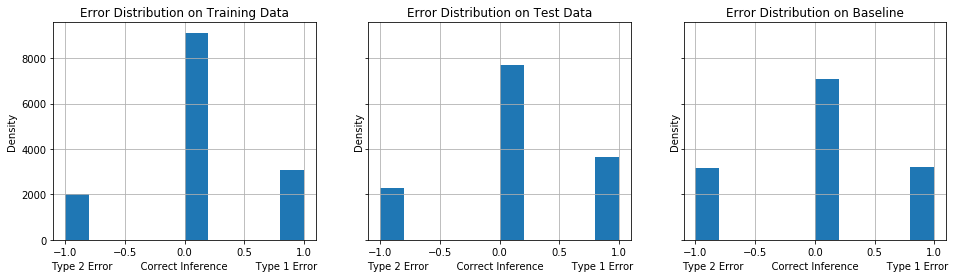

,importance
election_turnout_score,133
license_score,121
urbanicity,110
children_present_score,110
pr_european_descent,99
never_trumper_score,99
offyear_turnout_score,96
incomeXage,96
affirmative_action_resentment_score,95
teaparty_score,94


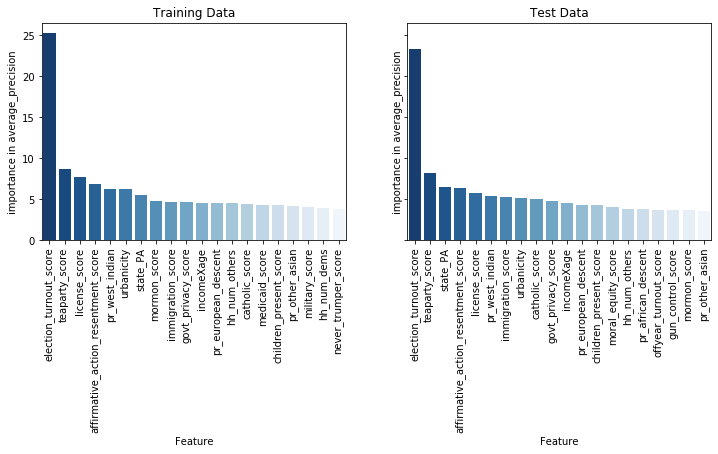

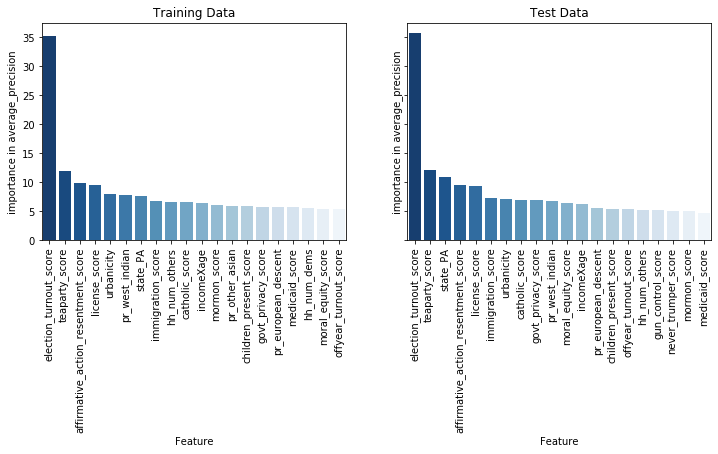

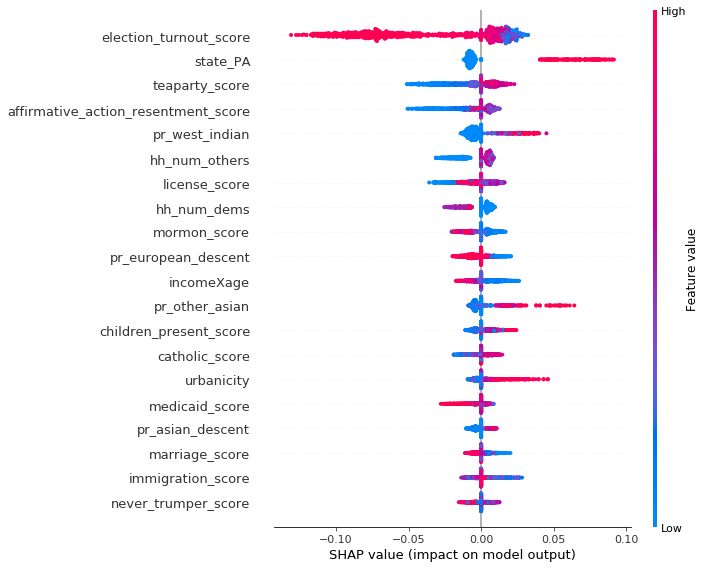

In [36]:
plot_model_info(models[keys[10]], analysis_df, y_label, baseline_label, train_range, test_range, baseline_range)